# Data loading

In [1]:
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams["figure.dpi"] = 100
sns.set_style("whitegrid")
sns.set_context("notebook")

In [2]:
CWD = Path("/Users/phipag/Git/powertac/ev-simulation-model")

In [3]:
raw_df = pd.read_csv(
    CWD / "data" / "norway_residential" / "Dataset 1_EV charging reports.csv",
    index_col=False,
    sep=";",
    parse_dates=["Start_plugin", "End_plugout"],
    decimal=",",
)
raw_df

session_ID Garage_ID  User_ID User_type Shared_ID        Start_plugin  \
0              1      AdO3   AdO3-4   Private       NaN 2018-12-21 10:20:00   
1              2      AdO3   AdO3-4   Private       NaN 2018-12-21 10:24:00   
2              3      AdO3   AdO3-4   Private       NaN 2018-12-21 11:33:00   
3              4      AdO3   AdO3-2   Private       NaN 2018-12-22 16:15:00   
4              5      AdO3   AdO3-2   Private       NaN 2018-12-24 22:03:00   
...          ...       ...      ...       ...       ...                 ...   
6873        6874      UT15   UT15-2   Private       NaN 2020-01-31 17:57:00   
6874        6875     AsO10  AsO10-1   Private       NaN 2020-01-31 18:32:00   
6875        6876       Bl2    Bl2-1   Private       NaN 2020-01-31 19:25:00   
6876        6877       UT7    UT7-1   Private       NaN 2020-01-31 19:27:00   
6877        6878       Bl2  Share-7    Shared  Shared-7 2020-01-31 20:42:00   

      Start_plugin_hour         End_plugout  End_plugout_hour  El_kWh  \
0                    10 2018-12-21 10:23:00              10.0    0.30   
1                    10 2018-12-21 10:32:00              10.0    0.87   
2                    11 2018-12-21 19:46:00              19.0   29.87   
3                    16 2018-12-23 16:40:00              16.0   15.56   
4                    22 2018-12-24 23:02:00              23.0    3.62   
...                 ...                 ...               ...     ...   
6873                 17 2020-01-31 22:29:00              22.0   13.43   
6874                 18 2020-01-31 21:43:00              21.0    9.10   
6875                 19 2020-01-31 20:37:00              20.0    4.28   
6876                 19 2020-01-31 19:48:00              19.0    2.31   
6877                 20 2020-01-31 23:53:00              23.0   20.14   

      Duration_hours month_plugin weekdays_plugin             Plugin_category  \
0           0.050000          Dec          Friday         late morning (9-12)   
1           0.136667          Dec          Friday         late morning (9-12)   
2           8.216389          Dec          Friday         late morning (9-12)   
3          24.419722          Dec        Saturday      late afternoon (15-18)   
4           0.970556          Dec          Monday  late evening (21-midnight)   
...              ...          ...             ...                         ...   
6873        4.530000          Jan          Friday      late afternoon (15-18)   
6874        3.182222          Jan          Friday       early evening (18-21)   
6875        1.203889          Jan          Friday       early evening (18-21)   
6876        0.352500          Jan          Friday       early evening (18-21)   
6877        3.184167          Jan          Friday       early evening (18-21)   

           Duration_category  
0          Less than 3 hours  
1          Less than 3 hours  
2     Between 6 and 9  hours  
3         More than 18 hours  
4          Less than 3 hours  
...                      ...  
6873   Between 3 and 6 hours  
6874   Between 3 and 6 hours  
6875       Less than 3 hours  
6876       Less than 3 hours  
6877   Between 3 and 6 hours  

[6878 rows x 15 columns]

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   session_ID         6878 non-null   int64         
 1   Garage_ID          6878 non-null   object        
 2   User_ID            6878 non-null   object        
 3   User_type          6878 non-null   object        
 4   Shared_ID          1412 non-null   object        
 5   Start_plugin       6878 non-null   datetime64[ns]
 6   Start_plugin_hour  6878 non-null   int64         
 7   End_plugout        6844 non-null   datetime64[ns]
 8   End_plugout_hour   6844 non-null   float64       
 9   El_kWh             6878 non-null   float64       
 10  Duration_hours     6844 non-null   float64       
 11  month_plugin       6878 non-null   object        
 12  weekdays_plugin    6878 non-null   object        
 13  Plugin_category    6878 non-null   object        
 14  Duration

In [5]:
raw_df.describe()

session_ID  Start_plugin_hour  End_plugout_hour       El_kWh  \
count  6878.000000        6878.000000       6844.000000  6878.000000   
mean   3439.500000          16.325240         12.546902    12.720744   
std    1985.651908           4.363108          5.256756    11.787938   
min       1.000000           0.000000          0.000000     0.010000   
25%    1720.250000          15.000000          7.000000     5.200000   
50%    3439.500000          17.000000         12.000000     9.050000   
75%    5158.750000          19.000000         17.000000    16.090000   
max    6878.000000          23.000000         23.000000    80.860000   

       Duration_hours  
count     6844.000000  
mean        11.504440  
std         14.148168  
min          0.003333  
25%          2.789028  
50%         10.026250  
75%         15.221181  
max        255.029444

# Raw data exploration

## Automatic with `pandas_profiling`

Uncomment this markdown to re-run the report generation:
```python
profile = ProfileReport(raw_df, explorative=True)
profile.to_file("exploration_report.html")
```

## Manual exploration

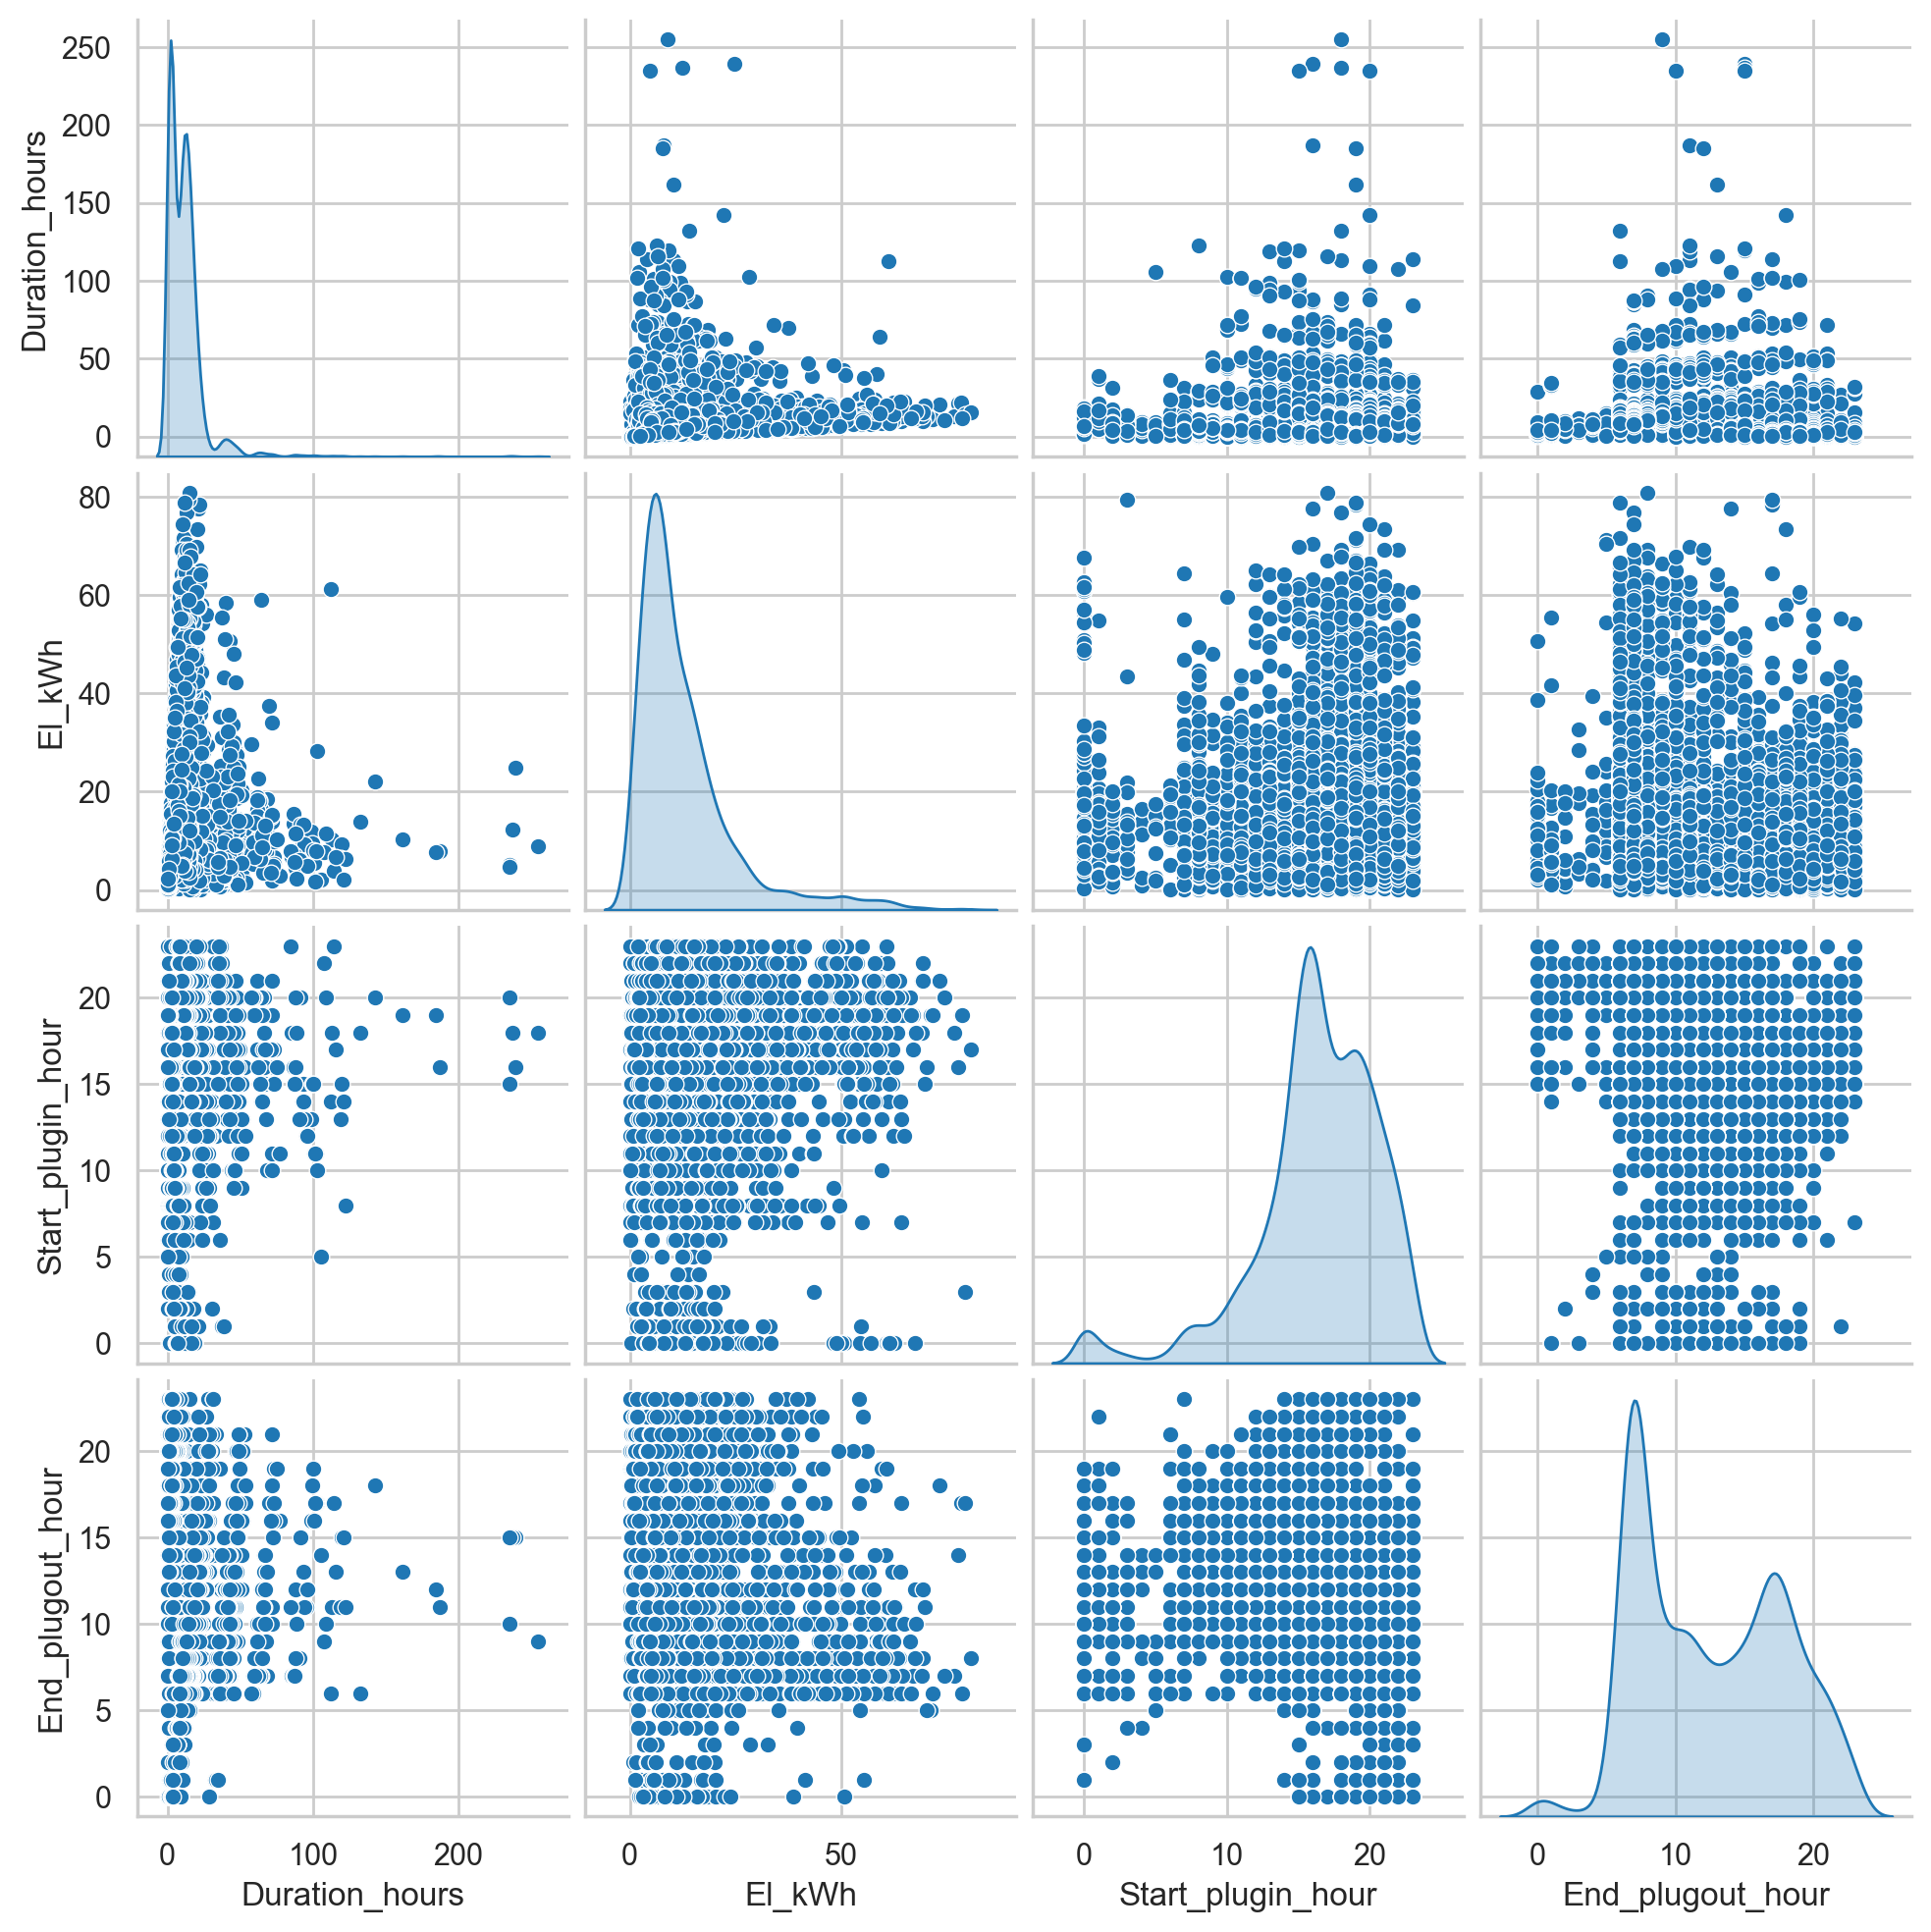

In [6]:
sns.pairplot(
    data=raw_df,
    vars=["Duration_hours", "El_kWh", "Start_plugin_hour", "End_plugout_hour"],
    diag_kind="kde",
);

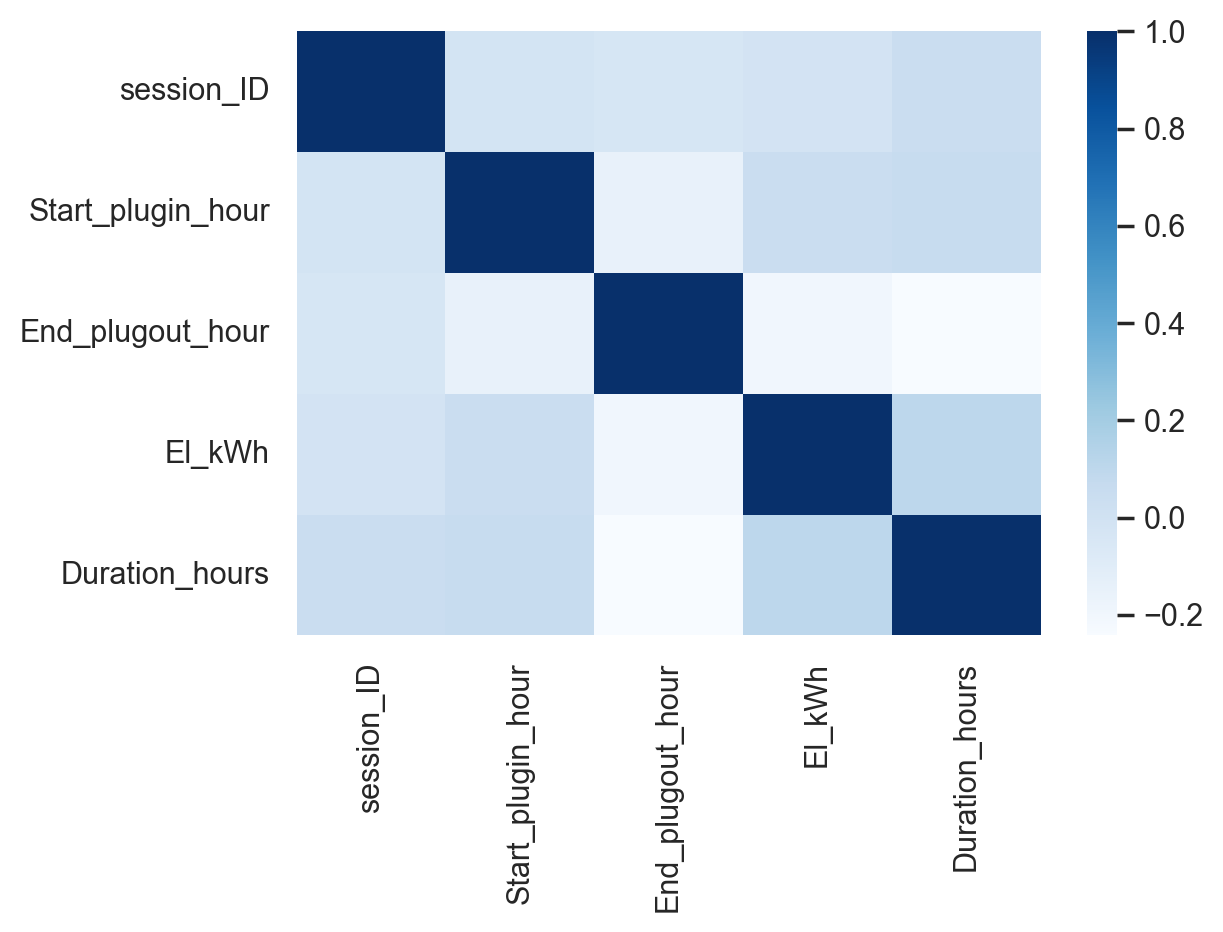

In [7]:
fig, ax = plt.subplots()
sns.heatmap(raw_df.corr(), cmap="Blues", ax=ax);

# Charging pattern exploration

In [8]:
charging_df = raw_df.melt(
    id_vars=["Start_plugin_hour", "End_plugout_hour"],
    value_vars=["Duration_hours", "El_kWh"],
)
charging_df

Start_plugin_hour  End_plugout_hour        variable      value
0                     10              10.0  Duration_hours   0.050000
1                     10              10.0  Duration_hours   0.136667
2                     11              19.0  Duration_hours   8.216389
3                     16              16.0  Duration_hours  24.419722
4                     22              23.0  Duration_hours   0.970556
...                  ...               ...             ...        ...
13751                 17              22.0          El_kWh  13.430000
13752                 18              21.0          El_kWh   9.100000
13753                 19              20.0          El_kWh   4.280000
13754                 19              19.0          El_kWh   2.310000
13755                 20              23.0          El_kWh  20.140000

[13756 rows x 4 columns]

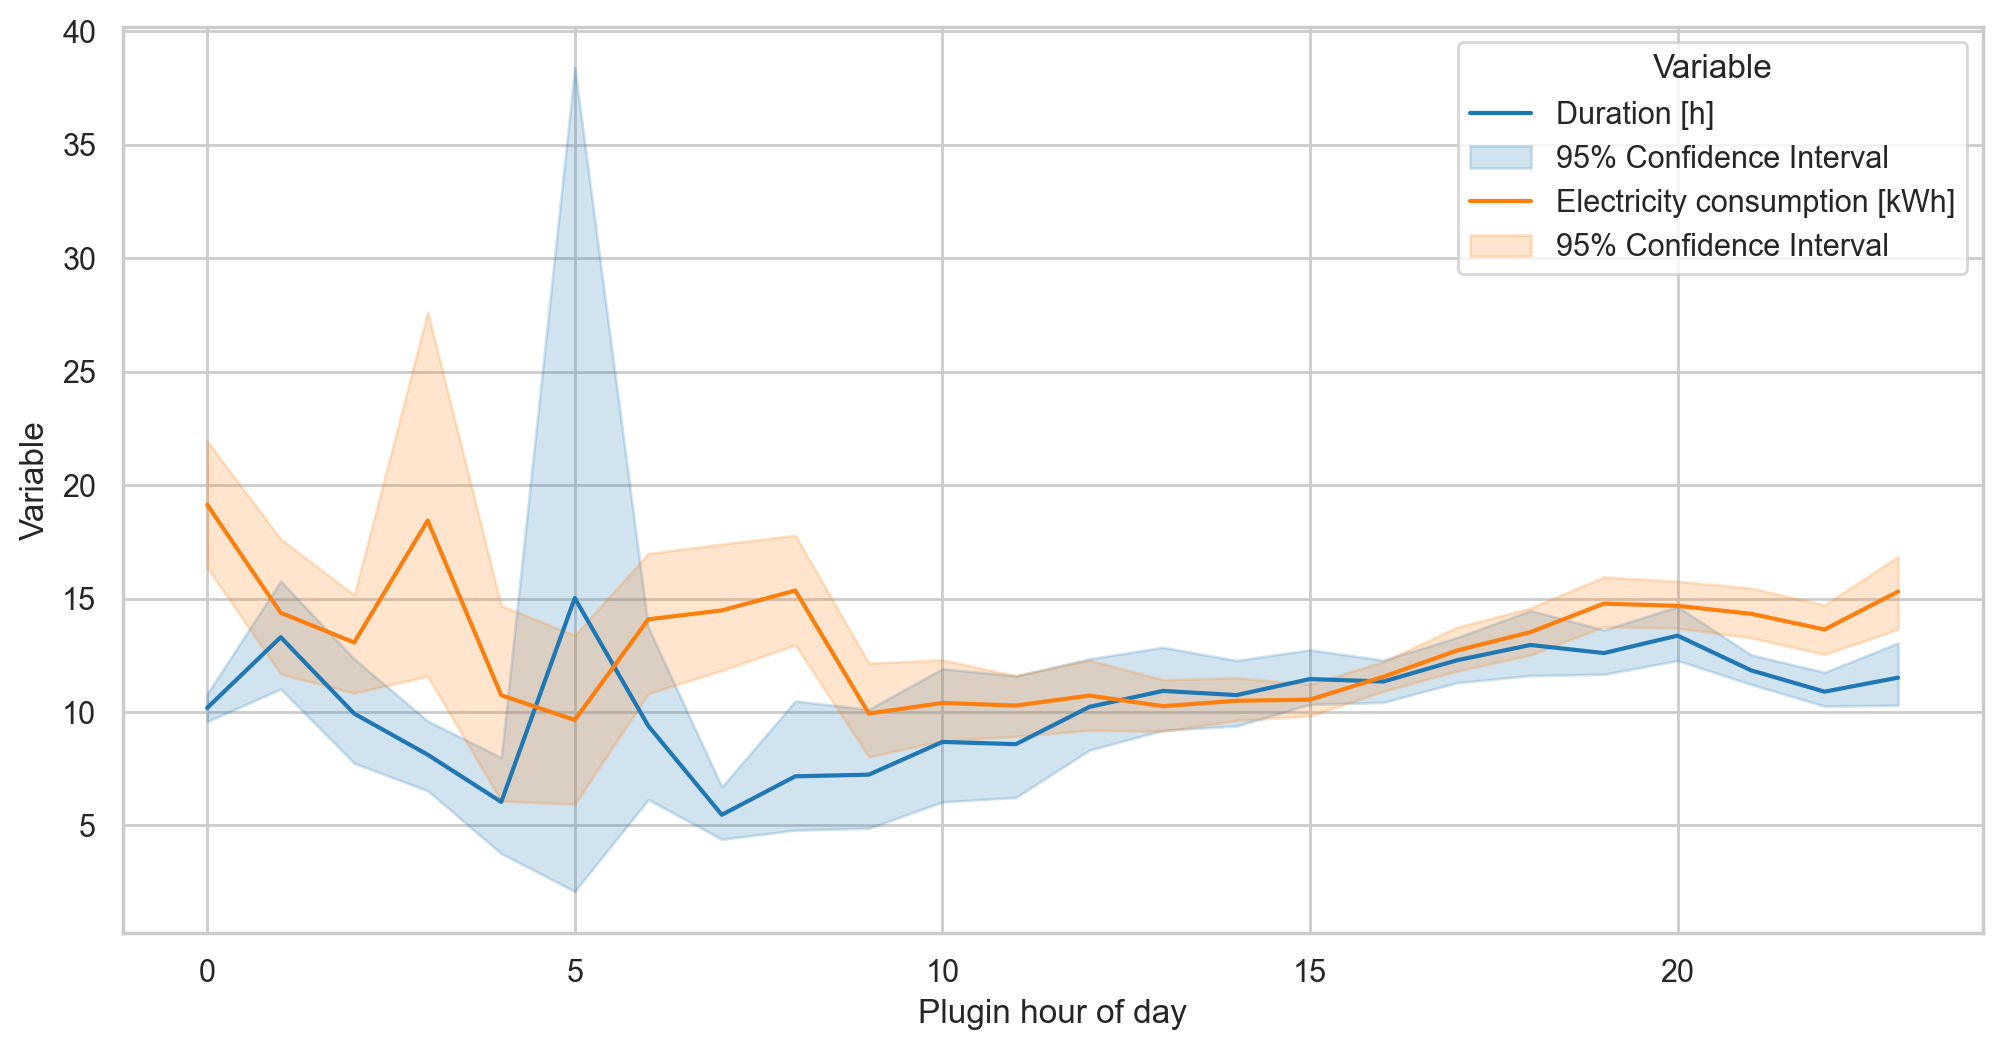

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x="Start_plugin_hour", y="value", data=charging_df, hue="variable", ax=ax)
ax.set_xlabel("Plugin hour of day")
ax.set_ylabel("Variable")
ax.legend(
    title="Variable",
    labels=[
        "Duration [h]",
        "95% Confidence Interval",
        "Electricity consumption [kWh]",
        "95% Confidence Interval",
    ],
);

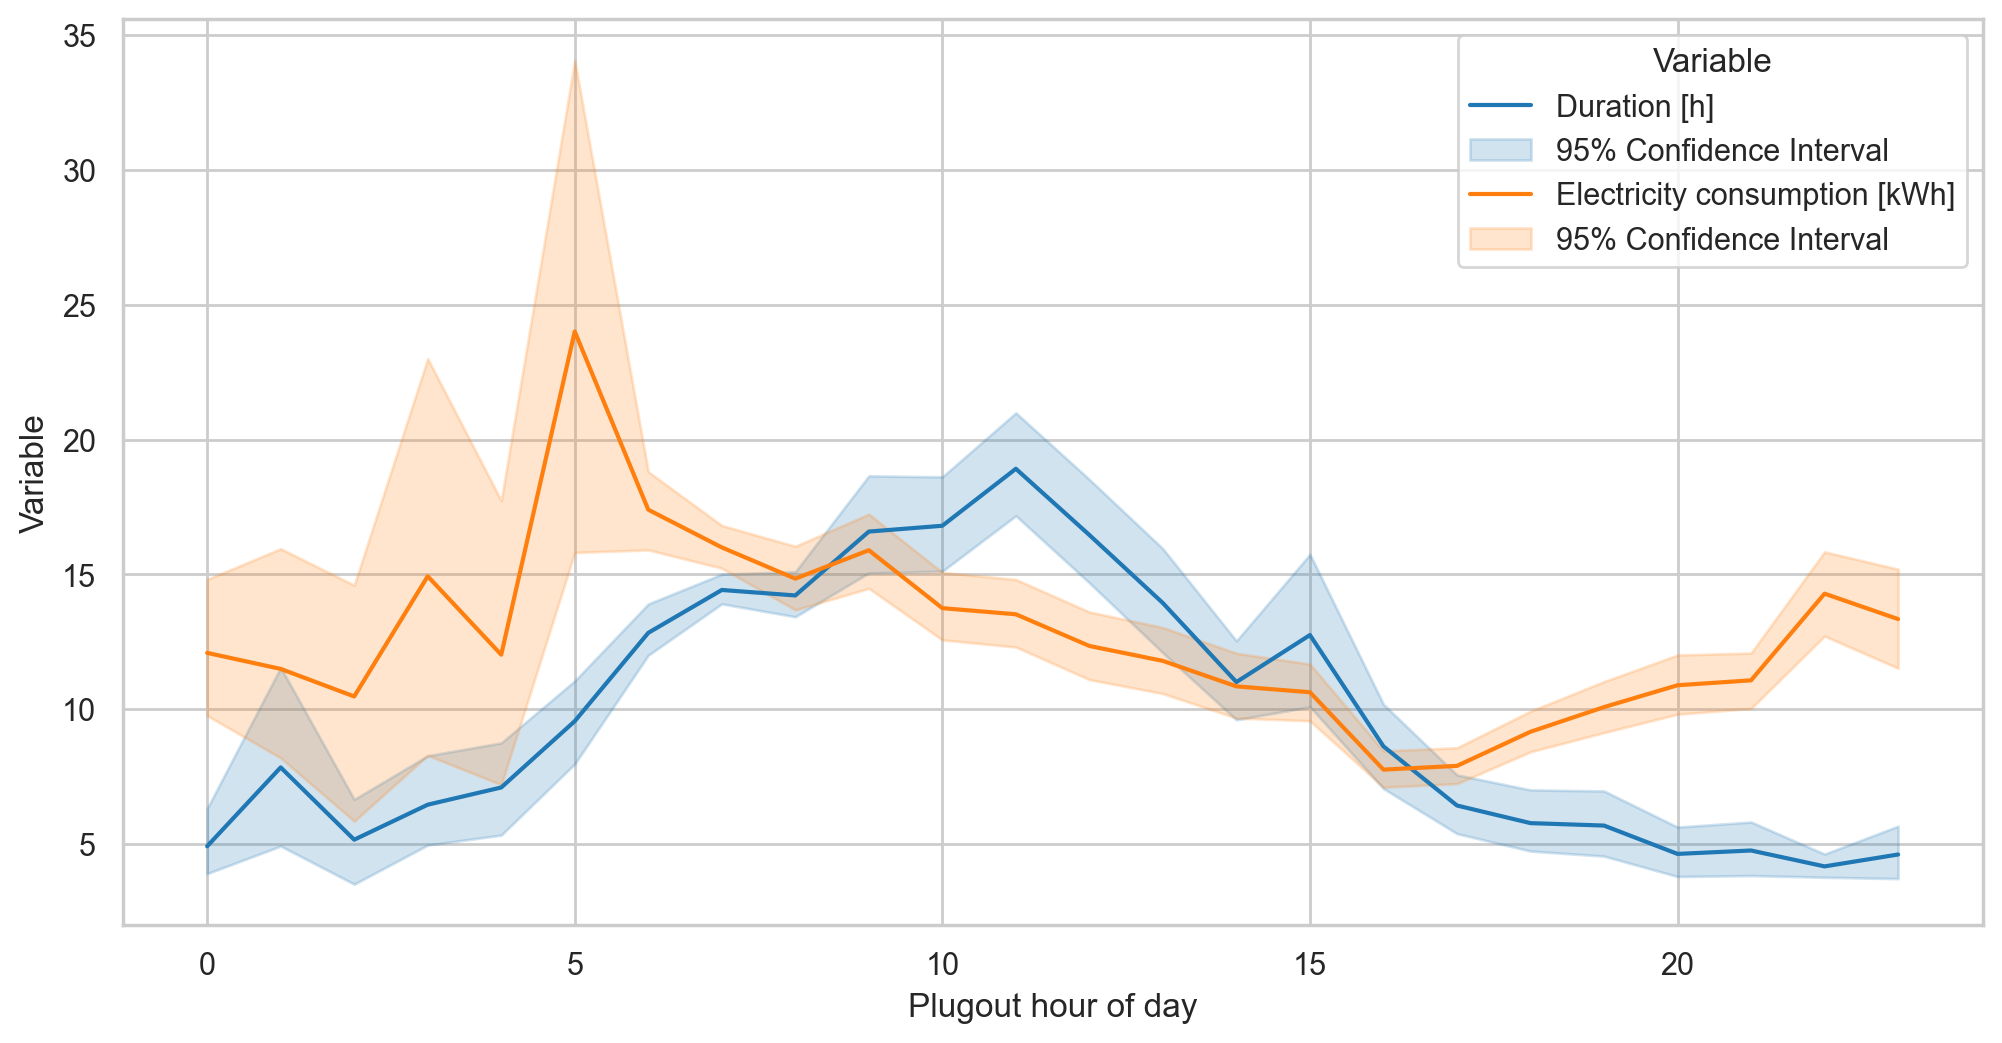

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x="End_plugout_hour", y="value", data=charging_df, hue="variable", ax=ax)
ax.set_xlabel("Plugout hour of day")
ax.set_ylabel("Variable")
ax.legend(
    title="Variable",
    labels=[
        "Duration [h]",
        "95% Confidence Interval",
        "Electricity consumption [kWh]",
        "95% Confidence Interval",
    ],
);

# Density estimation

## Exploring the densities

In [11]:
duration_df = raw_df[["Duration_hours", "Start_plugin_hour"]]
duration_df

Duration_hours  Start_plugin_hour
0           0.050000                 10
1           0.136667                 10
2           8.216389                 11
3          24.419722                 16
4           0.970556                 22
...              ...                ...
6873        4.530000                 17
6874        3.182222                 18
6875        1.203889                 19
6876        0.352500                 19
6877        3.184167                 20

[6878 rows x 2 columns]

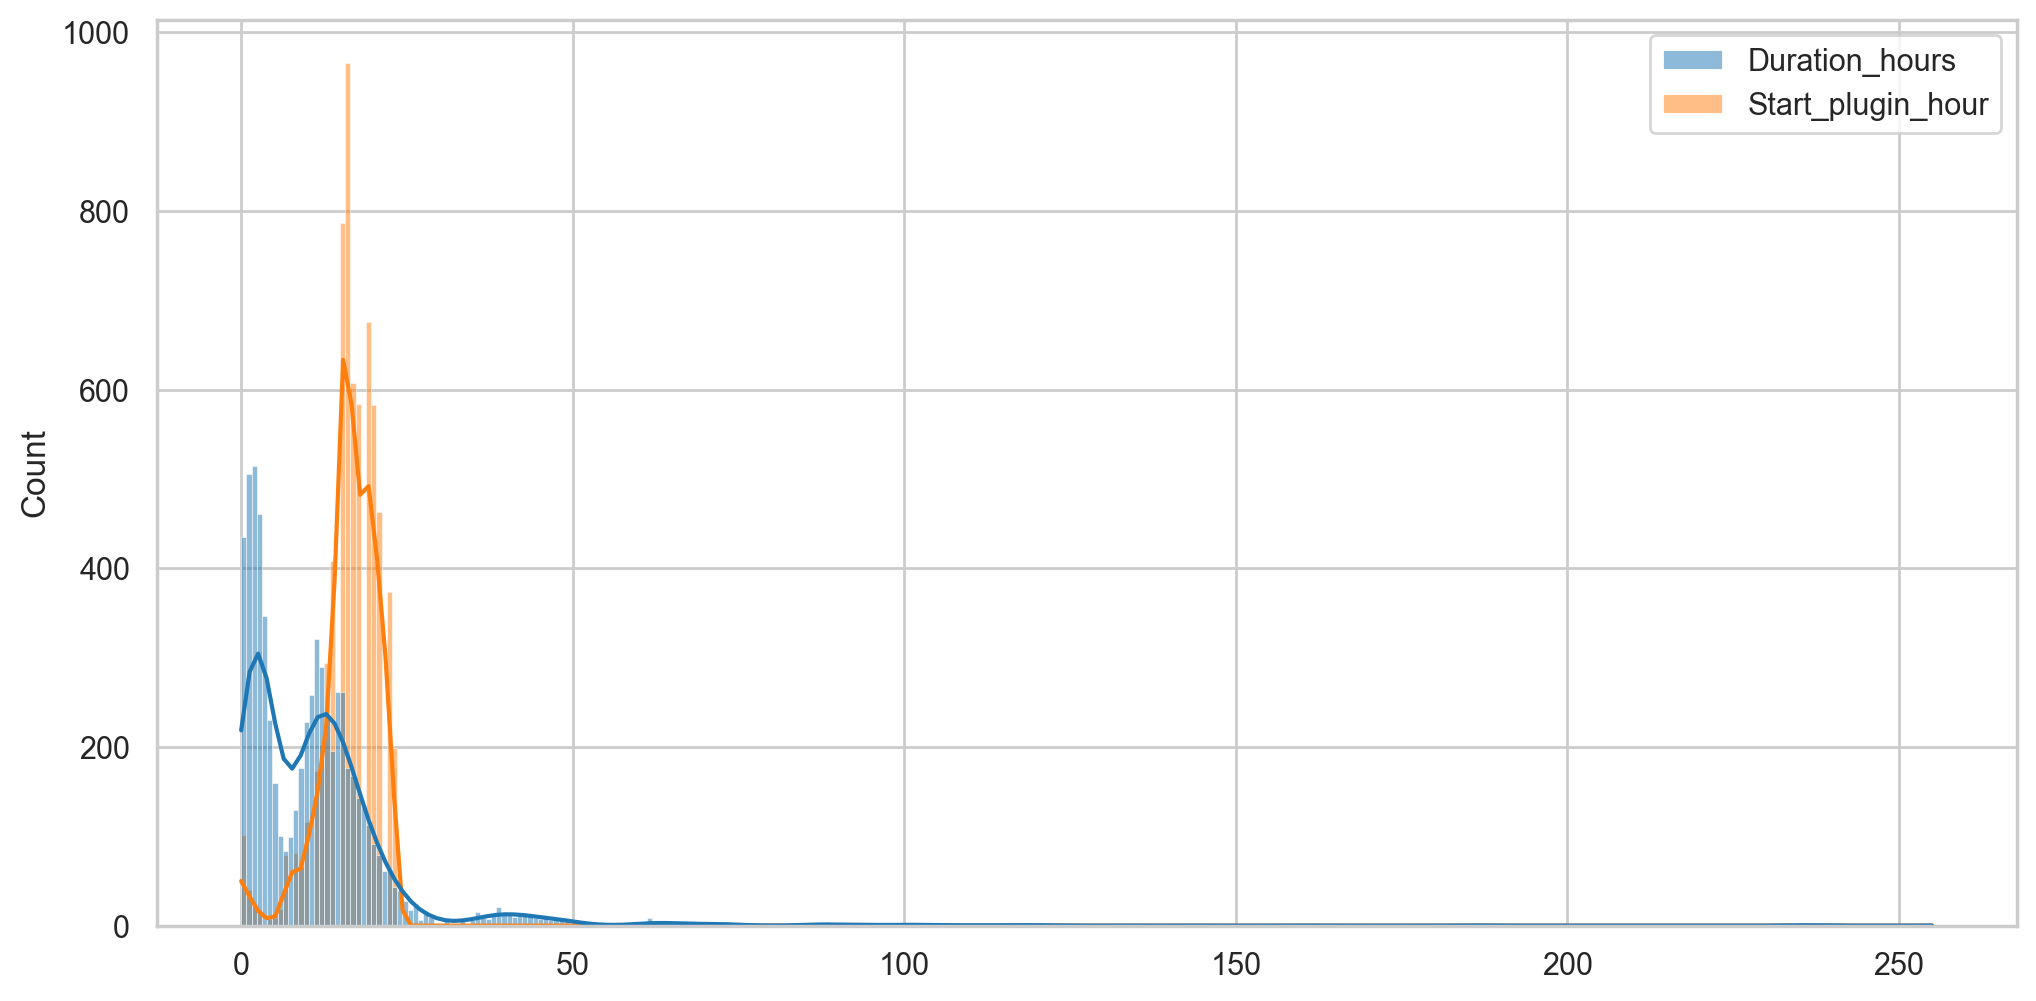

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(duration_df, kde=True, ax=ax);

Let's remove the outliers in `Duration_hours` first by filtering out datapoints with a `zscore < 3`.

In [13]:
duration_df = duration_df[
    (duration_df["Duration_hours"] - duration_df["Duration_hours"].mean()) / duration_df["Duration_hours"].std(ddof=0)
    < 3
].copy()

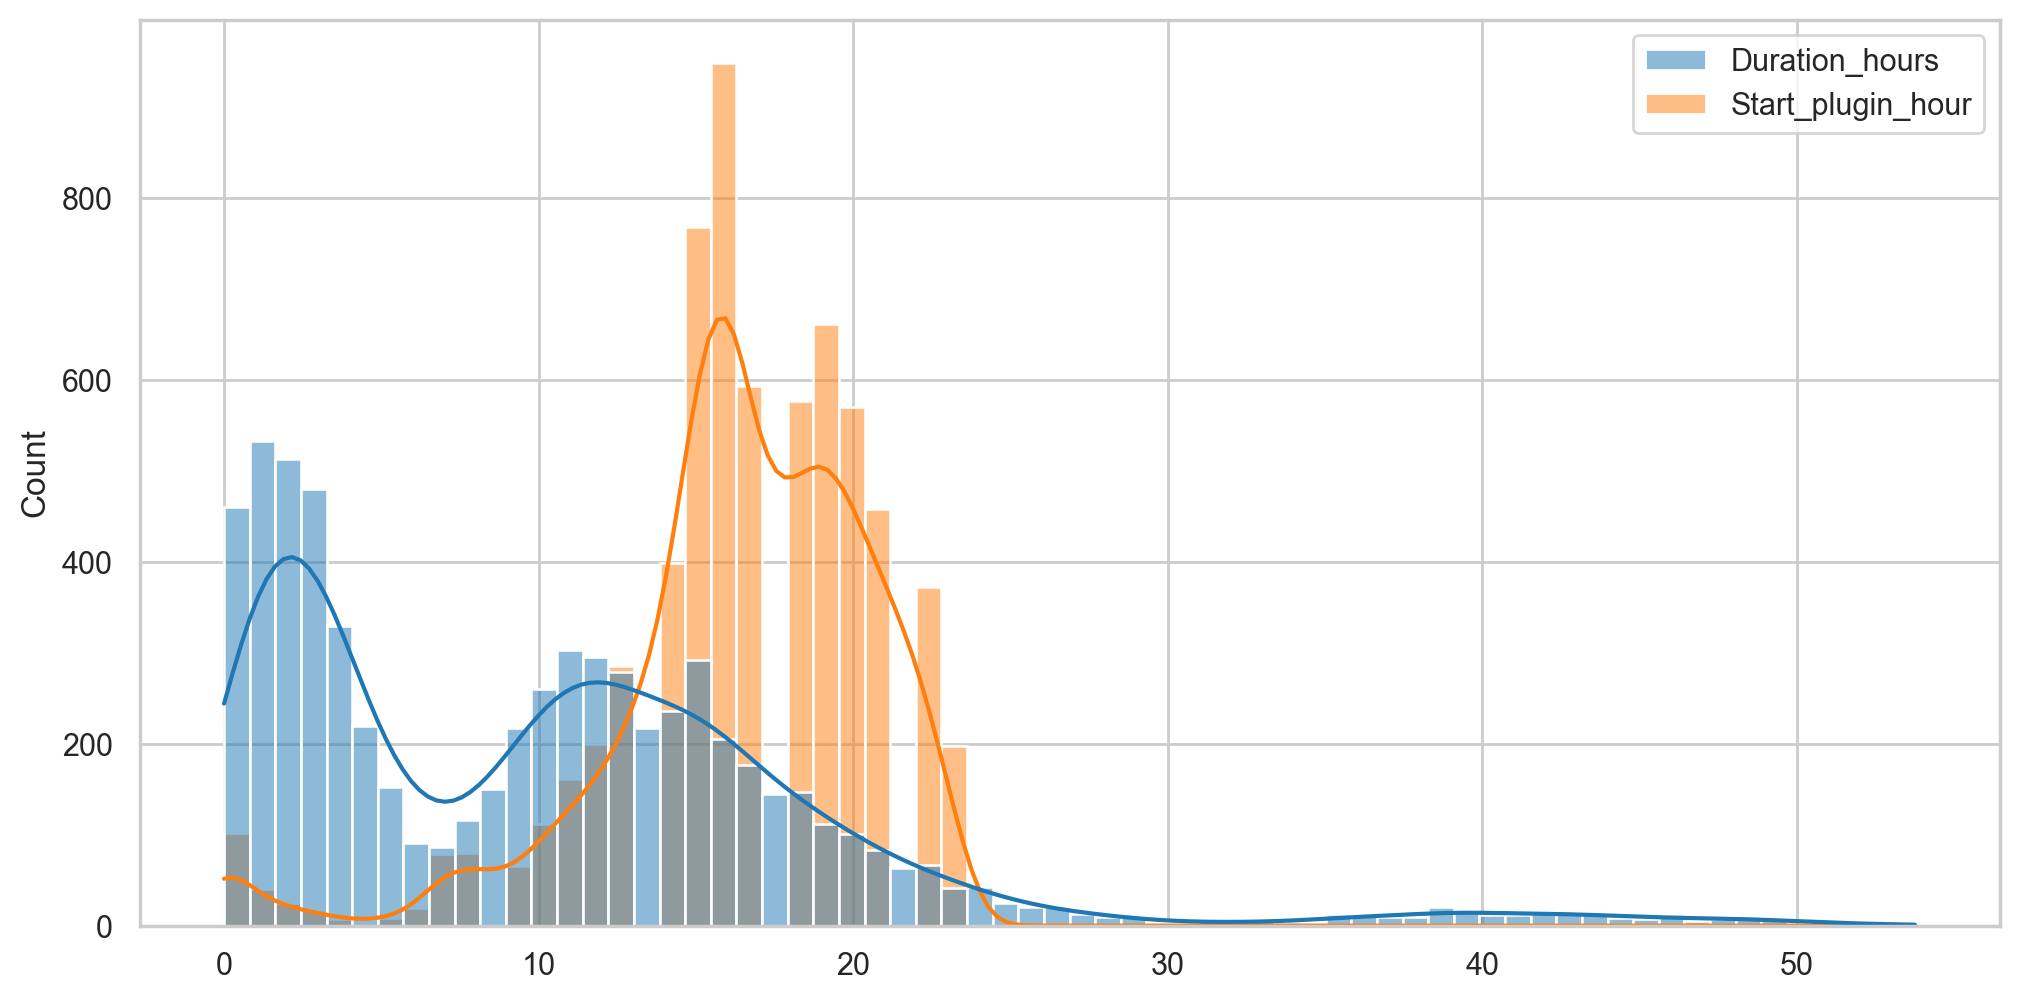

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(duration_df, kde=True, ax=ax);

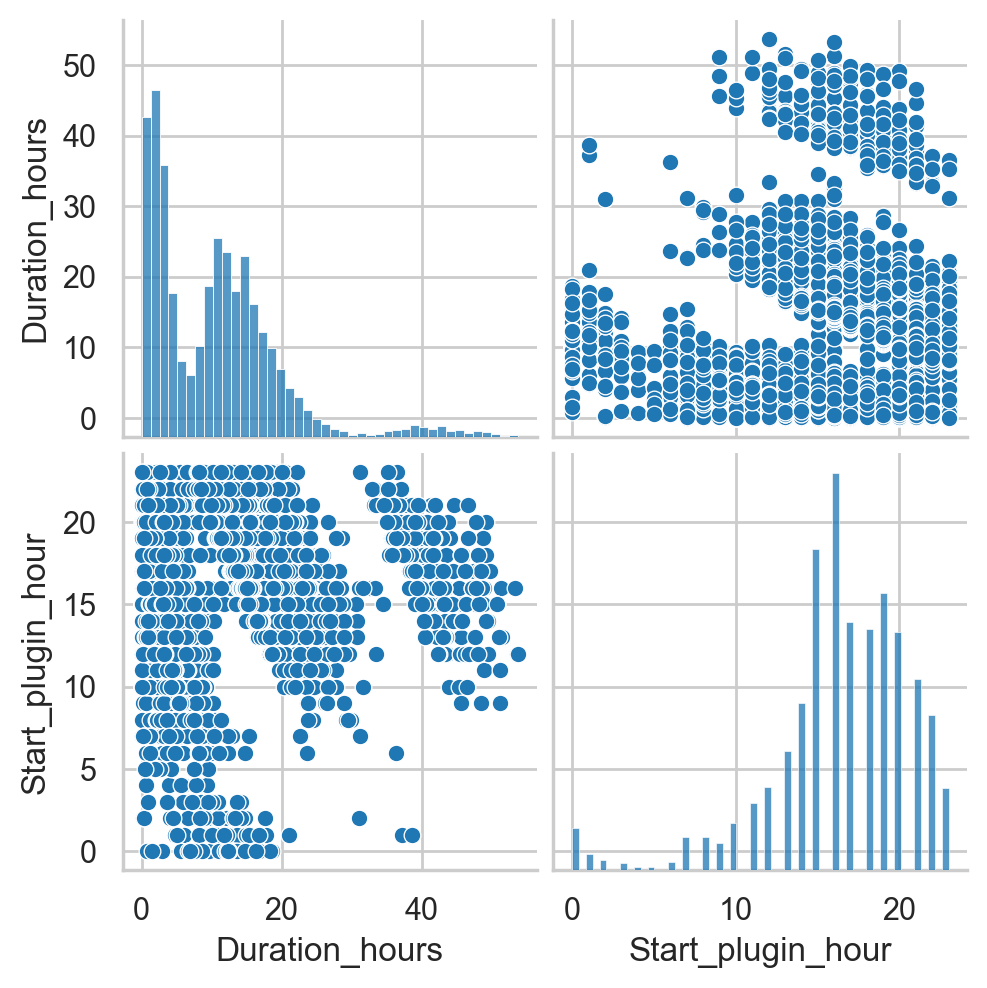

In [15]:
sns.pairplot(data=duration_df, diag_kind="hist");

## Estimating the densities with a Gaussian Mixture Model

In [16]:
duration_gm_df = duration_df.copy()

# TODO: Check the optimal number of components with a grid_search and evaluate using the Bayesian Information Criterion (BIC)
gm = GaussianMixture(n_components=3, random_state=0, covariance_type="full")
duration_gm_df["cluster"] = gm.fit_predict(duration_df)

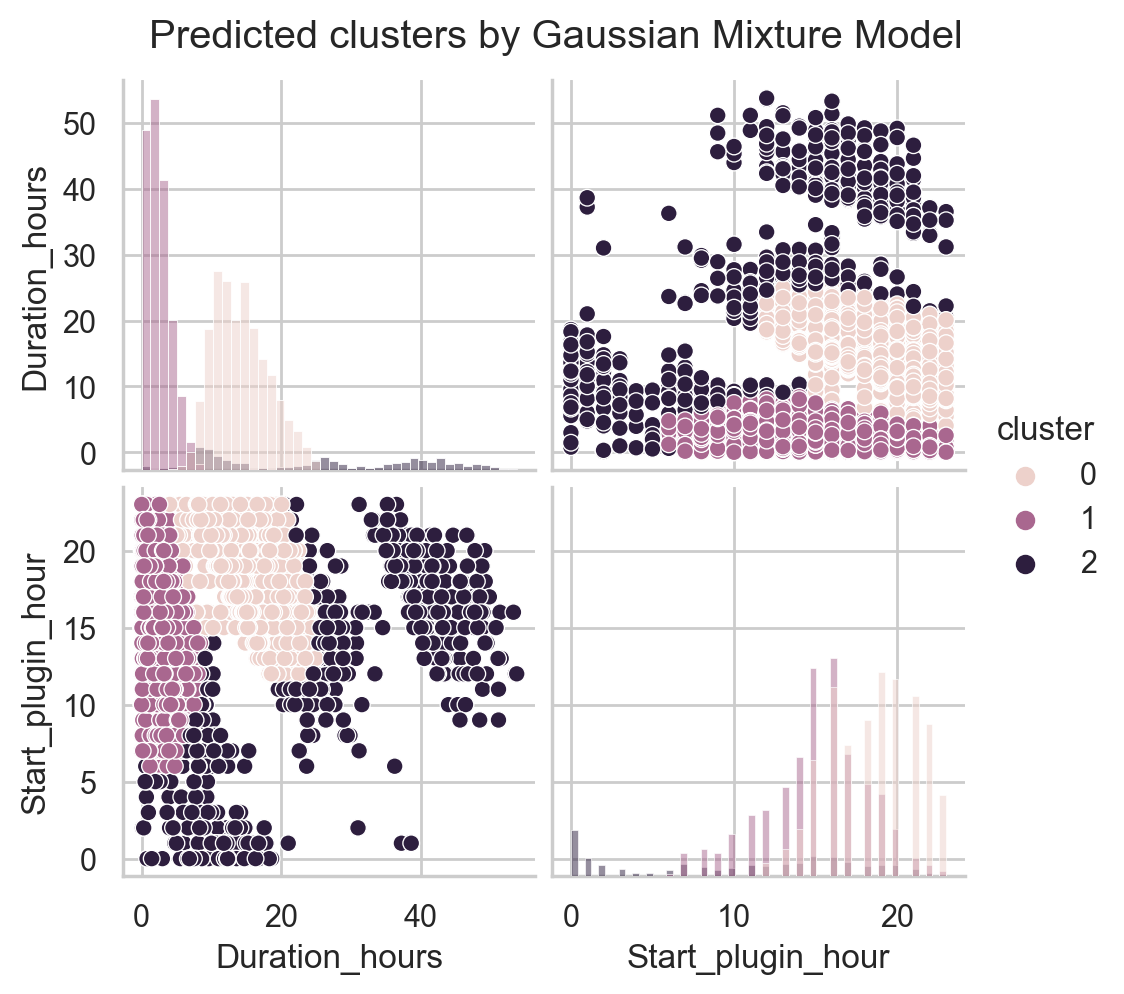

In [17]:
grid = sns.pairplot(data=duration_gm_df, hue="cluster", diag_kind="hist")
grid.figure.suptitle("Predicted clusters by Gaussian Mixture Model")
grid.tight_layout();

## Generating data from the fitted mixture distributions
This is the joint mixture distribution $p(\text{Duration_hours}, \text{Start_plugin_hour})$

In [18]:
samples, clusters = gm.sample(len(duration_df))
duration_generated_df = pd.DataFrame(samples, columns=duration_df.columns)
duration_generated_df["cluster"] = clusters
duration_generated_df

Duration_hours  Start_plugin_hour  cluster
0           6.153605          21.156924        0
1          10.393382          20.438935        0
2          14.932650          19.026710        0
3          14.866092          21.147673        0
4          11.354415          20.447537        0
...              ...                ...      ...
6742        7.233418           3.999742        2
6743       16.095710          12.731900        2
6744       34.715740          15.378847        2
6745       11.633872           7.261320        2
6746       12.805302           3.985965        2

[6747 rows x 3 columns]

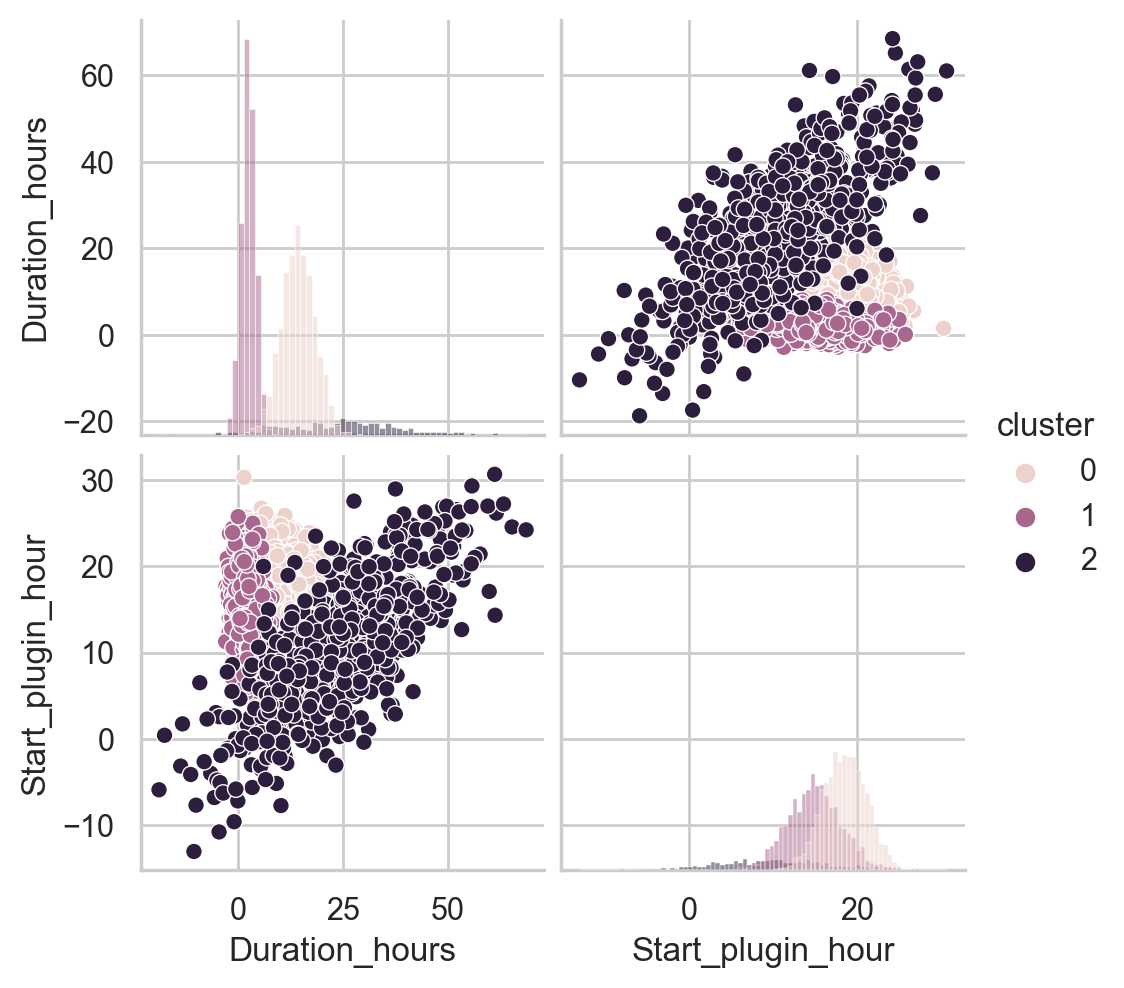

In [19]:
sns.pairplot(data=duration_generated_df, hue="cluster", diag_kind="hist");

In [20]:
gm.means_

array([[14.18569209, 18.6239272 ],
       [ 2.52152222, 15.04240564],
       [23.92304106, 10.43353559]])

In [21]:
gm.covariances_

array([[[ 15.59208417,  -7.00817288],
        [ -7.00817288,   6.95174765]],

       [[  2.87369069,  -1.08634273],
        [ -1.08634273,   9.91662376]],

       [[214.5741971 ,  75.54420164],
        [ 75.54420164,  50.190216  ]]])

In [22]:
gm.weights_

array([0.48785202, 0.41268764, 0.09946035])

## Compare generated `Duration_hours` with sample `Duration_hours`

In [23]:
duration_gen_vs_sample_df = pd.concat([duration_generated_df["Duration_hours"], duration_df["Duration_hours"]], axis=1)
duration_gen_vs_sample_df.columns = ["Duration hours (generated)", "Duration hours (true sample)"]

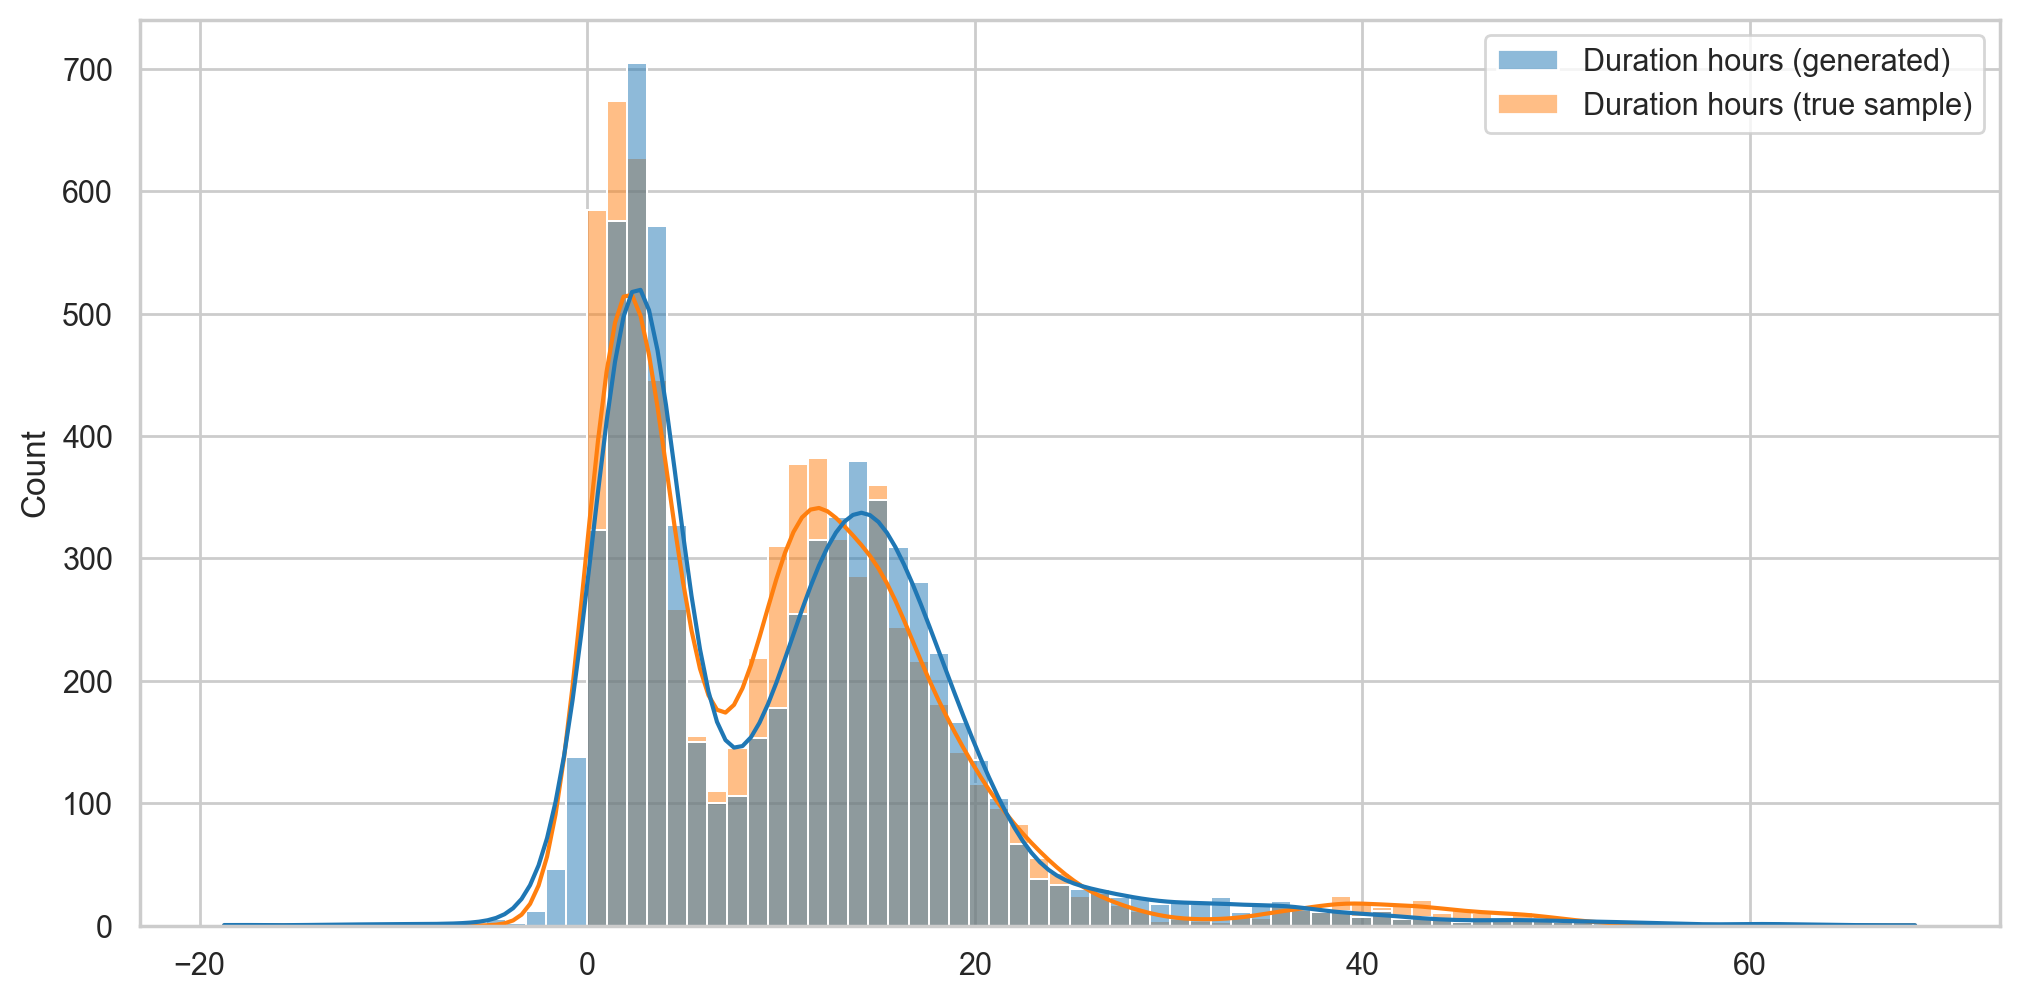

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(duration_gen_vs_sample_df, kde=True, ax=ax);

## Conditional distribution $p(\text{Duration_hours} | \text{Start_plugin_hour})$

### True conditional distributions

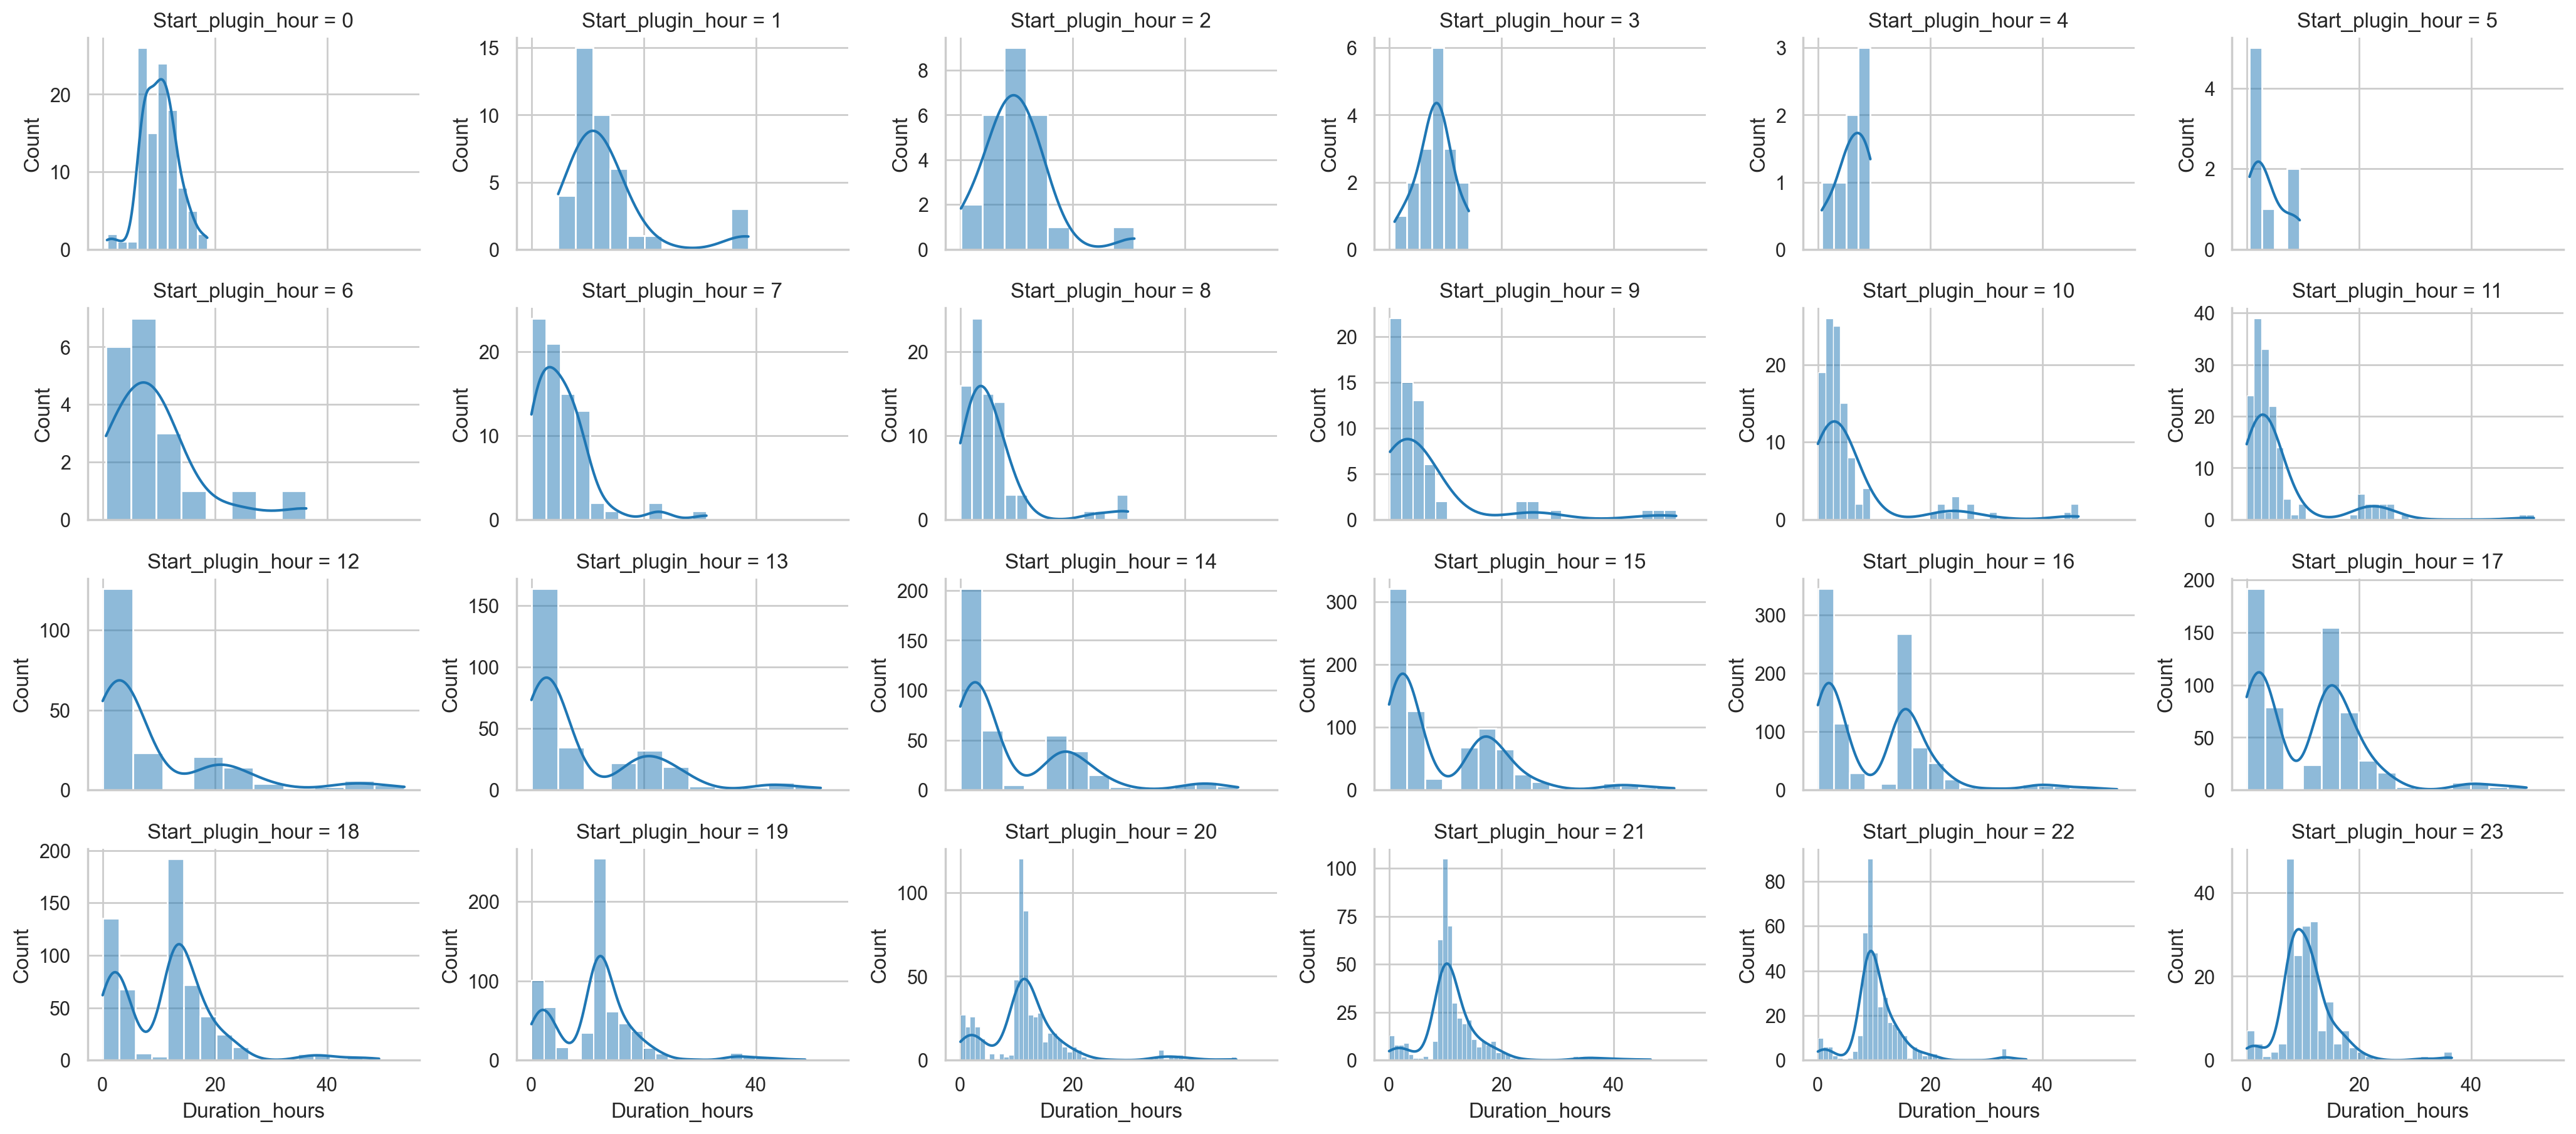

In [25]:
g = sns.FacetGrid(duration_gm_df, col="Start_plugin_hour", col_wrap=6, height=2.3, aspect=1.5, sharey=False)
g.map(sns.histplot, "Duration_hours", kde=True);

### True conditional distributions colored by GMM cluster

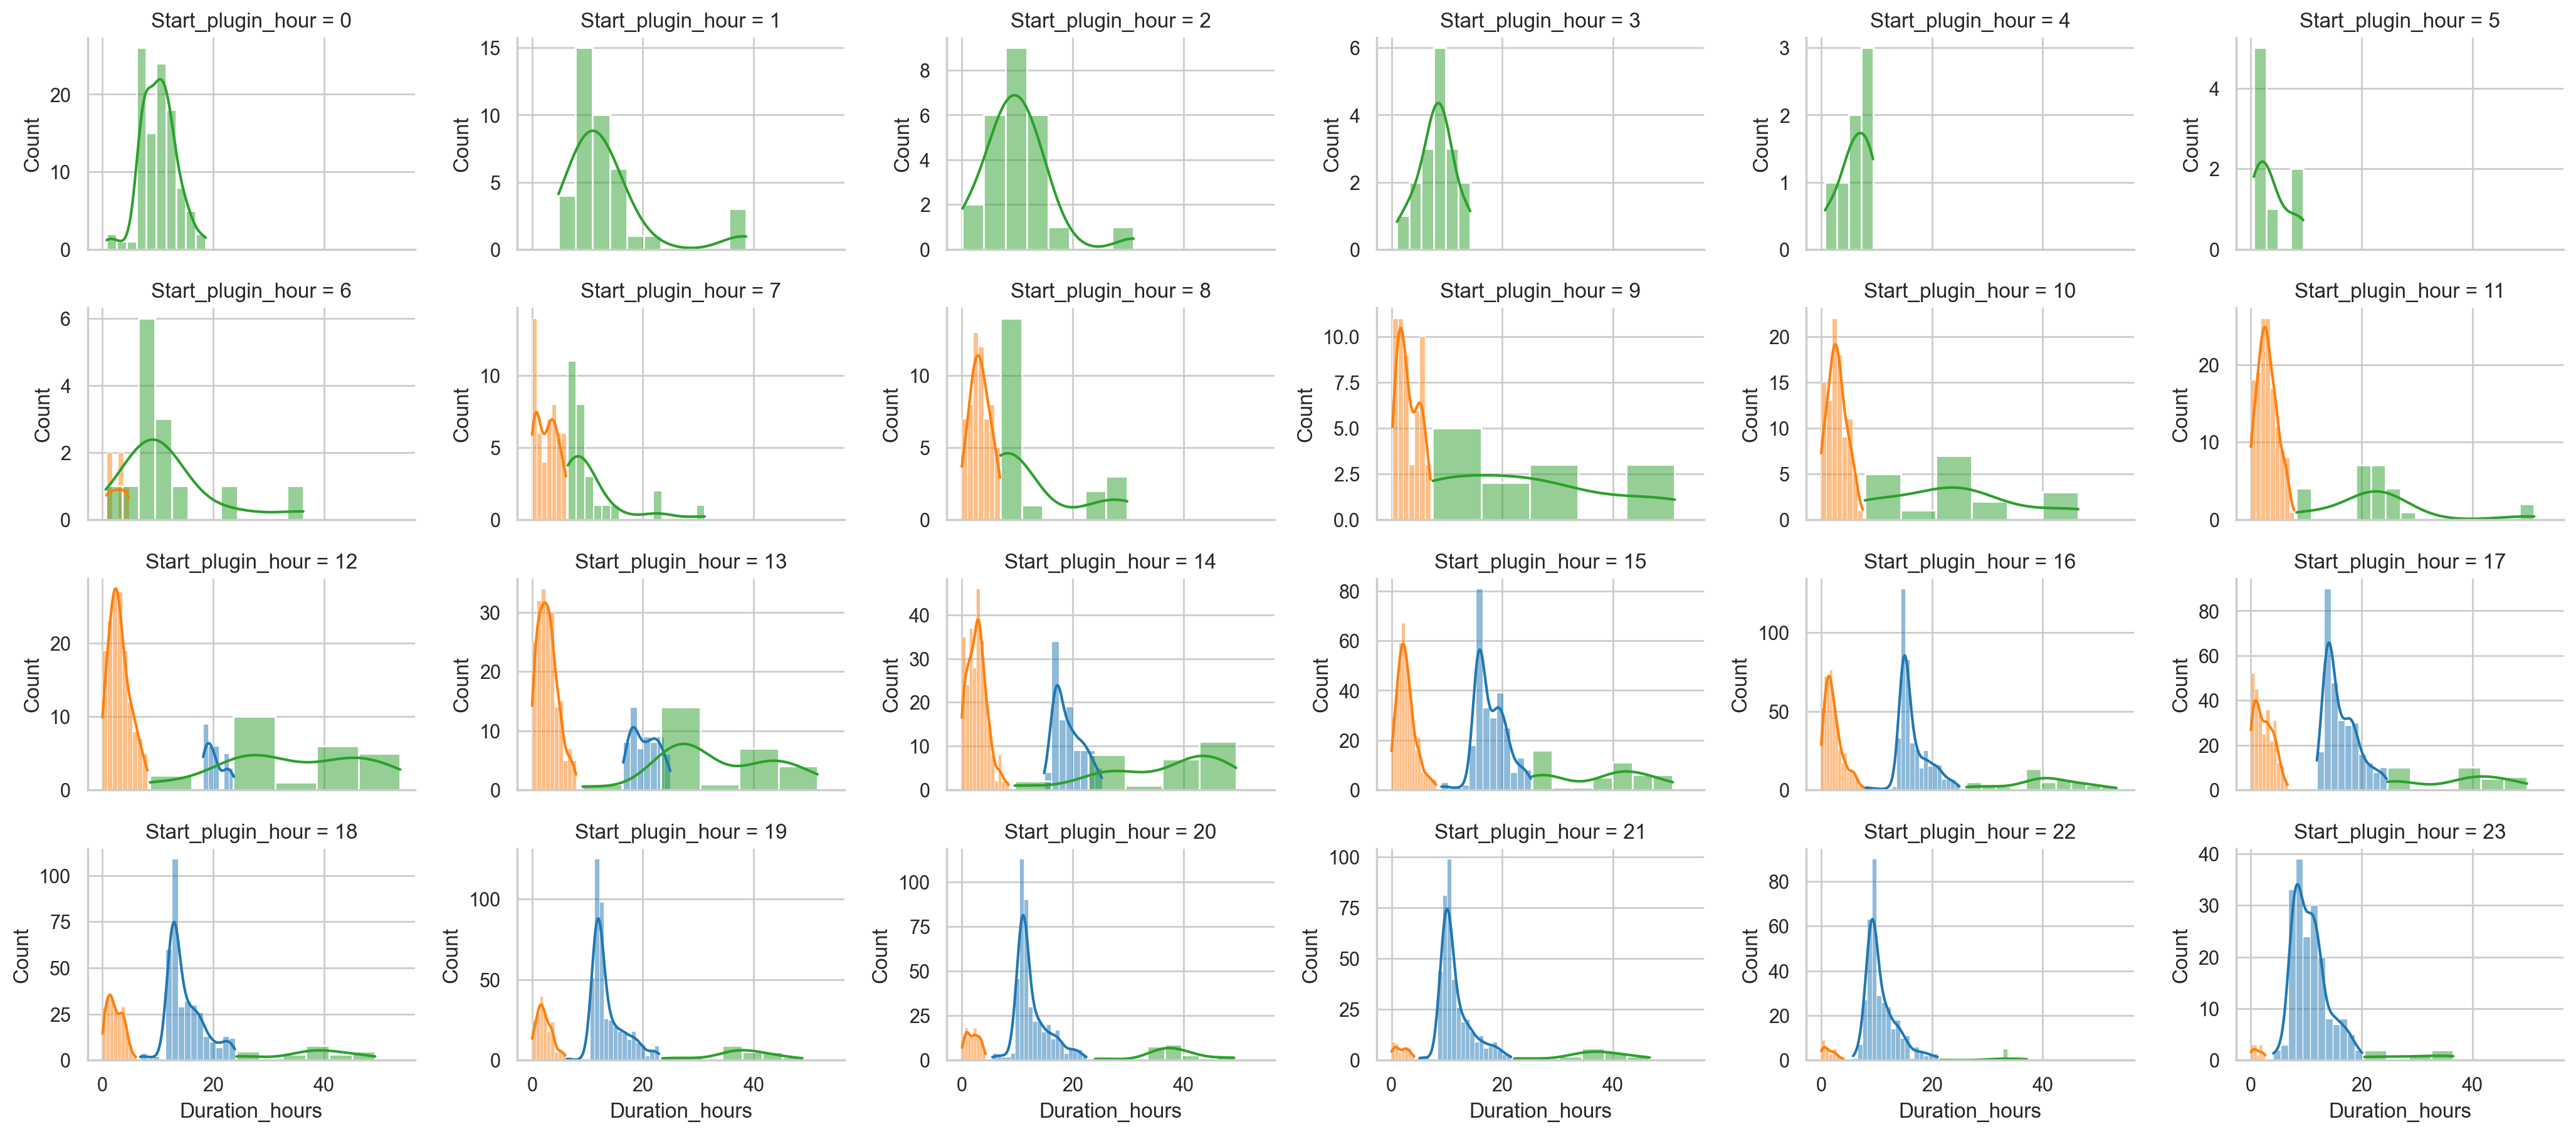

In [26]:
g = sns.FacetGrid(
    duration_gm_df, col="Start_plugin_hour", hue="cluster", col_wrap=6, height=2.3, aspect=1.5, sharey=False
)
g.map(sns.histplot, "Duration_hours", kde=True);

### Estimated conditional distributions by GMM
Now, we want to calculate the conditional distribution $p(\text{Duration_hours} | \text{Start_plugin_hour})$ estimated by the GMM. To do that, we have to derive the conditional distributions for each GMM mixture component. Luckily, the conditional distribution for one variable, given all other variables of a joint multivariate normal distribition is a normal distribution with well defined moments.

Formula to derive the conditional distribution $p(X | Y) \sim \mathcal{N}$ for a joint multivariate normal distribution $p(X, Y) \sim \mathcal{MVN}$ is on Wikipedia: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions.

In [27]:
# Inspired by this source: https://python.quantecon.org/multivariate_normal.html
class MultivariateNormal:
    """
    Class to represent a multivariate normal distribution. Allows computation
    of a conditional normal distribution.
    """

    def __init__(self, mean, cov) -> None:
        self.mean = np.array(mean)
        self.cov = np.atleast_2d(cov)

    def partition(self, k) -> None:
        """
        Given k, partition the random vector z into a size k vector z1
        and a size N-k vector z2.

        For the mean vector and the cov matrix this works as follows:
        Partition the mean vector mean into mean1 and mean2
        and the covariance matrix cov into cov11, cov12, cov21, cov22
        correspondingly.

        Compute the regression coefficients beta1 and beta2
        using the partitioned arrays.
        """
        mean = self.mean
        cov = self.cov

        self.means = [mean[:k], mean[k:]]
        self.covs = [[cov[:k, :k], cov[:k, k:]], [cov[k:, :k], cov[k:, k:]]]

        self.betas = [
            self.covs[0][1] @ np.linalg.inv(self.covs[1][1]),
            self.covs[1][0] @ np.linalg.inv(self.covs[0][0]),
        ]

    def cond_dist(self, ind, z):
        """
        Compute the conditional distribution of z1 given z2, or reversely.
        Argument ind determines whether we compute the conditional
        distribution of z1 (ind=0) or z2 (ind=1).

        Returns
        ---------
        mean_hat: ndarray(float, ndim=1)
            The conditional mean of z1 or z2.
        cov_hat: ndarray(float, ndim=2)
            The conditional covariance matrix of z1 or z2.
        """
        if not self.betas:
            raise ValueError(
                "Call self.partition(k) first to specify how to partition the joint multivariate normal distribution. "
                "Example: p(x1, x2, x3) and k=1 partitions the distribution at index 1 as p(x1 | x2, x2)."
            )

        beta = self.betas[ind]
        means = self.means
        covs = self.covs

        mean_hat = means[ind] + beta @ (z - means[1 - ind])
        cov_hat = covs[ind][ind] - beta @ covs[1 - ind][1 - ind] @ beta.T

        return mean_hat, cov_hat

    def marg_dist(self, ind):
        """
        Computes the marginal distribution for the variable at
        index given by ind. Returns the mean and covariance for
        a multivariate normal distribution.

        Example
        ---------
        Let p(x1, x2, x3) be the joint multivariate normal.
        If ind=1 the marginal distributiuon p(x2) will be returned.

        Returns
        ---------
        mean: ndarray(float, ndim=1)
            The conditional mean of z1 or z2.
        cov_hat: ndarray(float, ndim=2)
            The conditional covariance matrix of z1 or z2.
        """
        return np.array([self.mean[ind]]), np.array([[self.cov[ind][ind]]])

In [28]:
def select_mixture_component(means, covs, weights):
    """
    Selects mean and covariance of an array of means and covariances while
    accounting for the provided weights for each mixture components.
    """
    acc_weights = [np.sum(weights[:i]) for i in range(1, len(weights) + 1)]
    if not np.isclose(acc_weights[-1], 1):
        raise ValueError("Provided weights for mixture components are invalid. Must sum up to one.")
    if not weights.shape[0] == means.shape[0]:
        raise ValueError(f"Shape of means and weights is not compatible.")
    if not weights.shape[0] == covs.shape[0]:
        raise ValueError(f"Shape of covariances and weights is not compatible.")

    r = np.random.uniform(0, 1)
    k = 0
    for i, threshold in enumerate(acc_weights):
        if r < threshold:
            k = i
            break
    selected_mean = means[k]
    selected_cov = covs[k]
    return selected_mean, selected_cov

In [29]:
def get_conditional_for_first_var(mean, cov, conditional):
    """
    Helper method to get the conditional distribution with
    the first variable conditional on all other variables.
    """
    mvn = MultivariateNormal(mean, cov)
    # Partitions p(x, y) to p(x | y)
    mvn.partition(1)
    return mvn.cond_dist(0, conditional)

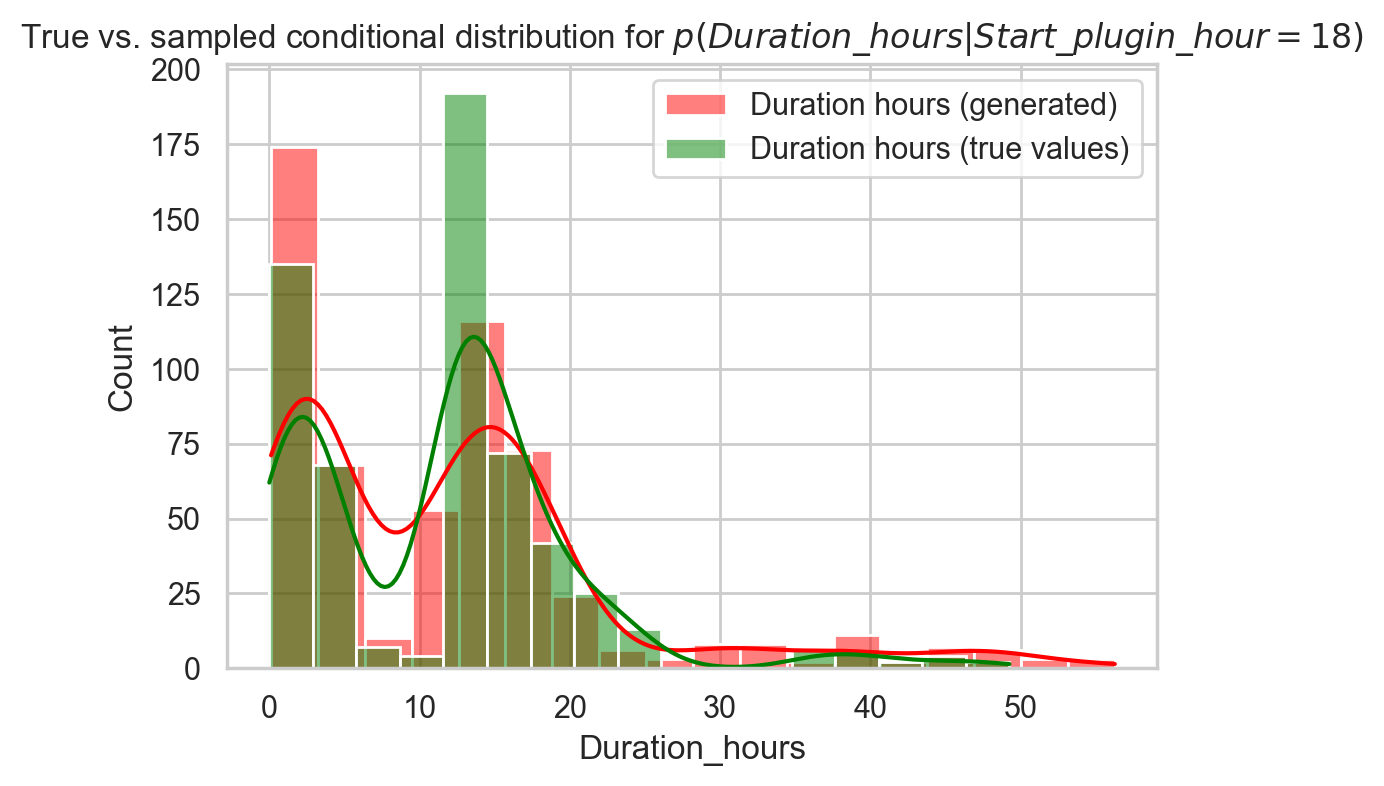

In [30]:
cond_start_plugin_hour = 18
true_data = duration_df[duration_df["Start_plugin_hour"] == cond_start_plugin_hour]["Duration_hours"]

sample_data = np.empty(0, dtype=float)
for _ in range(len(true_data)):
    mean, cov = get_conditional_for_first_var(
        *select_mixture_component(gm.means_, gm.covariances_, gm.weights_), cond_start_plugin_hour
    )
    sample = np.random.multivariate_normal(mean, cov, 1)
    # Sample again if sampled value is smaller or equal to zero
    while sample <= 0:
        sample = np.random.multivariate_normal(mean, cov, 1)
    sample_data = np.append(sample_data, sample)

fig, ax = plt.subplots()
sns.histplot(sample_data, color="red", label="Duration hours (generated)", kde=True, ax=ax)
sns.histplot(true_data, color="green", label="Duration hours (true values)", kde=True, ax=ax)
ax.set_title(
    f"True vs. sampled conditional distribution for $p(Duration\_hours | Start\_plugin\_hour = {cond_start_plugin_hour})$"
)
ax.legend();

In [31]:
duration_conditional_gen_df = pd.DataFrame()
for hour in range(24):
    len_true_data: int = len(duration_df[duration_df["Start_plugin_hour"] == hour])
    sample_data = np.empty(0, dtype=float)
    for _ in range(len_true_data):
        # Get conditional distribition for Duration_hours by fixing Start_plugin_hour = hour
        mean, cov = get_conditional_for_first_var(
            *select_mixture_component(gm.means_, gm.covariances_, gm.weights_), hour
        )
        sample = np.random.multivariate_normal(mean, cov, 1)
        # Sample again if sampled value is smaller or equal to zero
        while sample <= 0:
            sample = np.random.multivariate_normal(mean, cov, 1)
        sample_data = np.append(sample_data, sample)
    duration_conditional_gen_df = pd.concat(
        [duration_conditional_gen_df, pd.DataFrame({"Duration_hours": sample_data, "Start_plugin_hour": hour})]
    )

In [32]:
duration_conditional_gen_vs_sample_df = pd.concat([duration_conditional_gen_df, duration_df], axis=0).reset_index(
    drop=True
)
duration_conditional_gen_vs_sample_df.loc[: len(duration_conditional_gen_df), "type"] = "Duration hours (generated)"
duration_conditional_gen_vs_sample_df.loc[len(duration_conditional_gen_df) :, "type"] = "Duration hours (true values)"
print(duration_conditional_gen_vs_sample_df["type"].value_counts())
duration_conditional_gen_vs_sample_df

Duration hours (generated)      6747
Duration hours (true values)    6747
Name: type, dtype: int64


Duration_hours  Start_plugin_hour                          type
0            3.535626                  0    Duration hours (generated)
1            3.500014                  0    Duration hours (generated)
2           32.693277                  0    Duration hours (generated)
3           36.561734                  0    Duration hours (generated)
4           31.356370                  0    Duration hours (generated)
...               ...                ...                           ...
13489        4.530000                 17  Duration hours (true values)
13490        3.182222                 18  Duration hours (true values)
13491        1.203889                 19  Duration hours (true values)
13492        0.352500                 19  Duration hours (true values)
13493        3.184167                 20  Duration hours (true values)

[13494 rows x 3 columns]

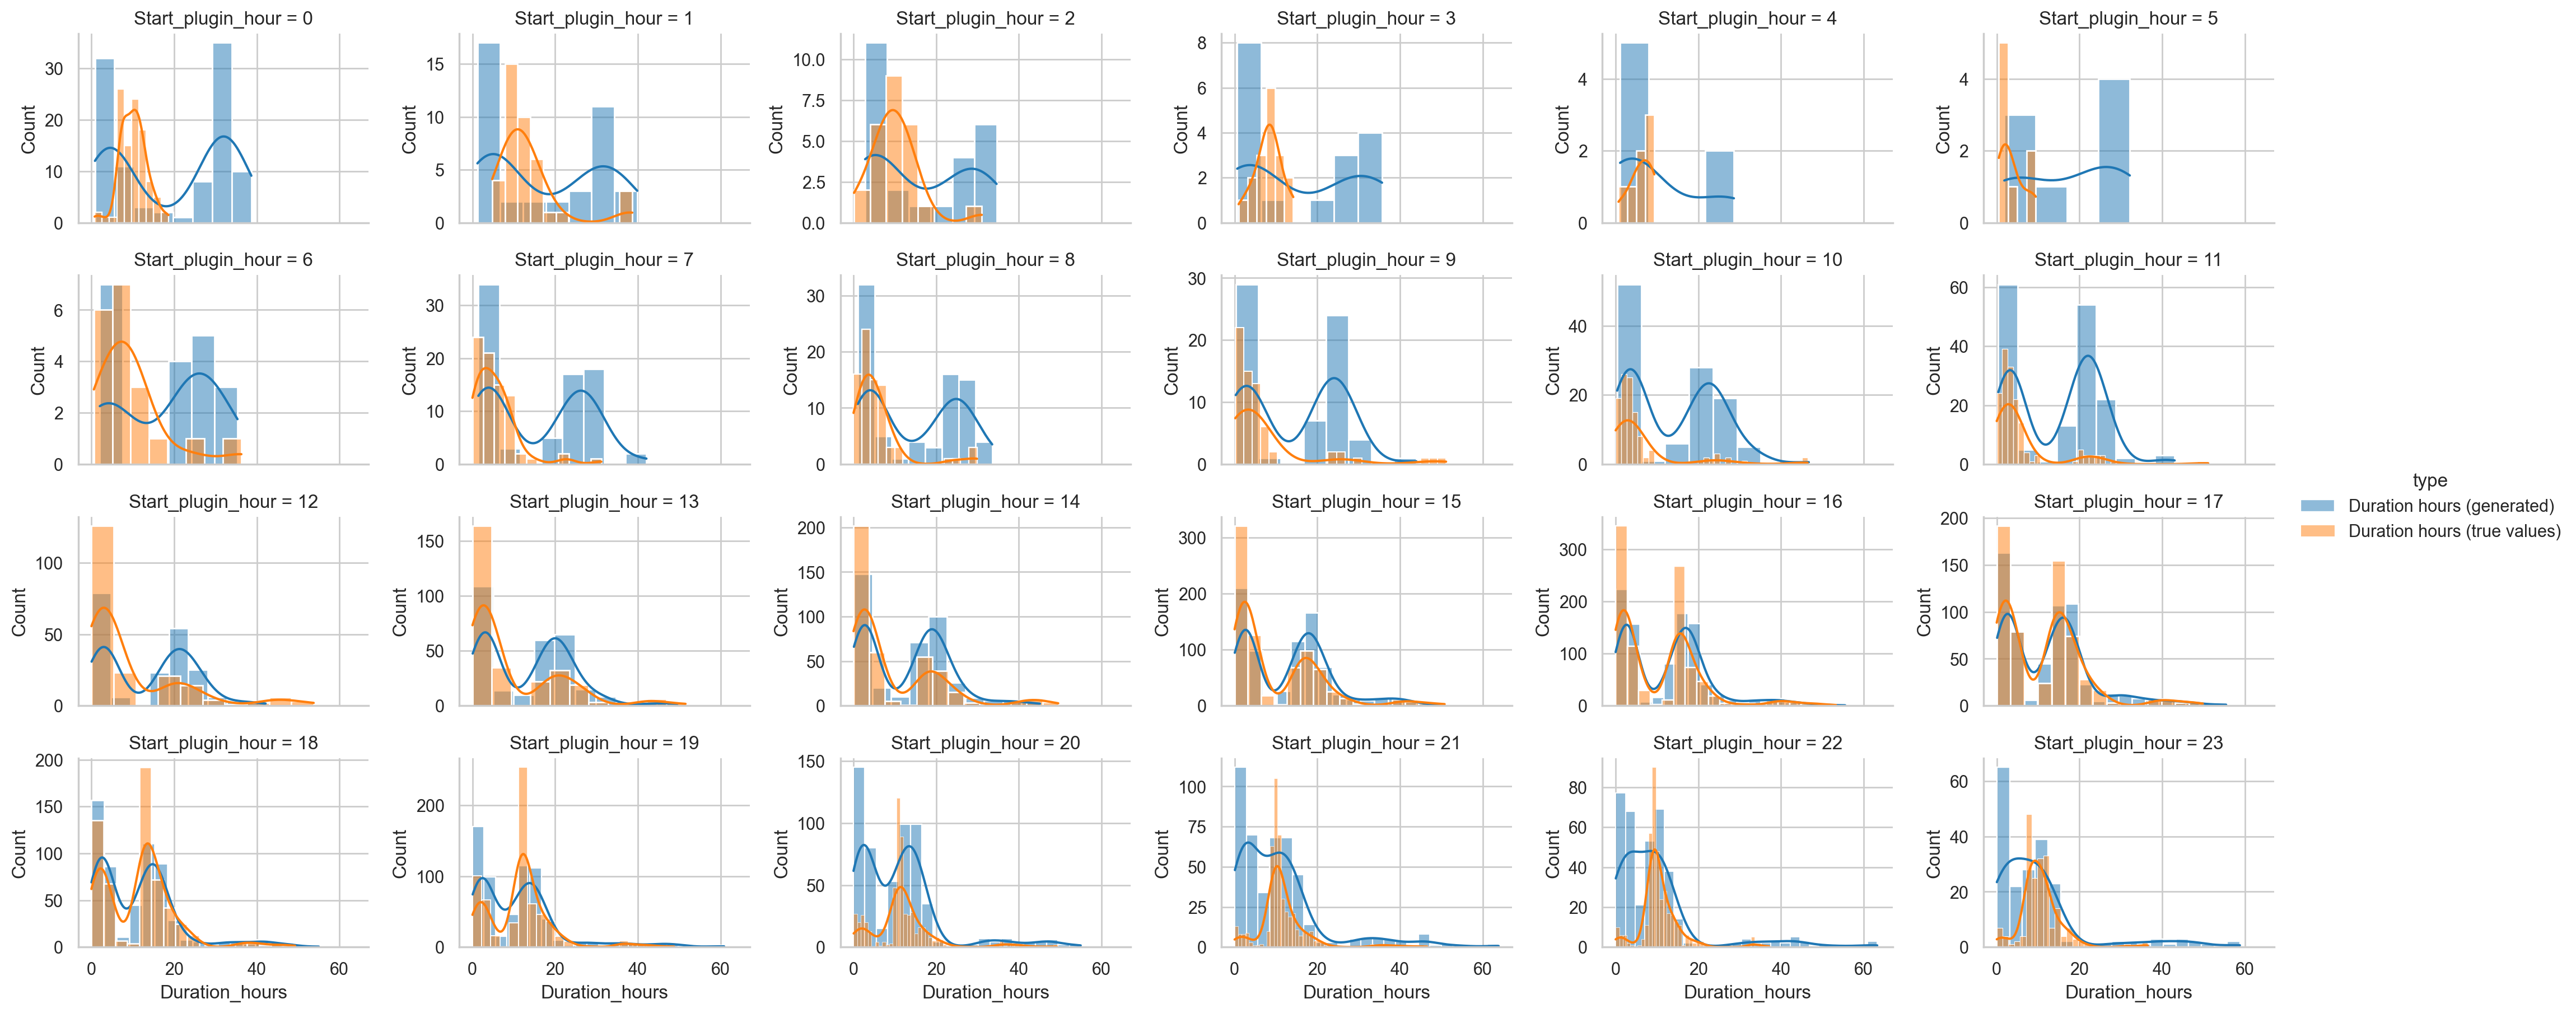

In [33]:
g = sns.FacetGrid(
    duration_conditional_gen_vs_sample_df,
    hue="type",
    col="Start_plugin_hour",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
)
g.map(sns.histplot, "Duration_hours", kde=True)
g.add_legend();

***Next steps:***
* Simulate: Duration in hours **and** need of KwH
* What about the state of charge (soc) when the vehicle arrives at the charger?
* Problem with conditional distributions: I think the weights need to change for the mixture components. E.g. at 1am in the night, only the green mixture component is found in the data.
  * Check the calculations here: We have to divide the weights by the sum of weighted marginal distributions: https://stats.stackexchange.com/questions/348941/general-conditional-distributions-for-multivariate-gaussian-mixtures
  * And here: https://github.com/plgreenLIRU/GMM_Conditional

### Draft for conditional mixture component weight calculation

In [34]:
conditional = 22
mvns = np.array([MultivariateNormal(mean, cov) for mean, cov in zip(gm.means_, gm.covariances_)])
weights = np.array(gm.weights_)

In [35]:
den_components = np.zeros(len(weights))
for i in range(len(weights)):
    marg_mean, marg_cov = mvns[i].marg_dist(1)
    den_components[i] = multivariate_normal(marg_mean, marg_cov).pdf(conditional) * weights[i]

# Find denominator
den = np.sum(den_components)

# Initialise list of new, conditional weights
new_weights = np.zeros(len(weights))

# Find new weights
for i in range(len(weights)):
    new_weights[i] = den_components[i] / den

list(new_weights)

[0.8435567512825464, 0.11812278005394306, 0.03832046866351065]

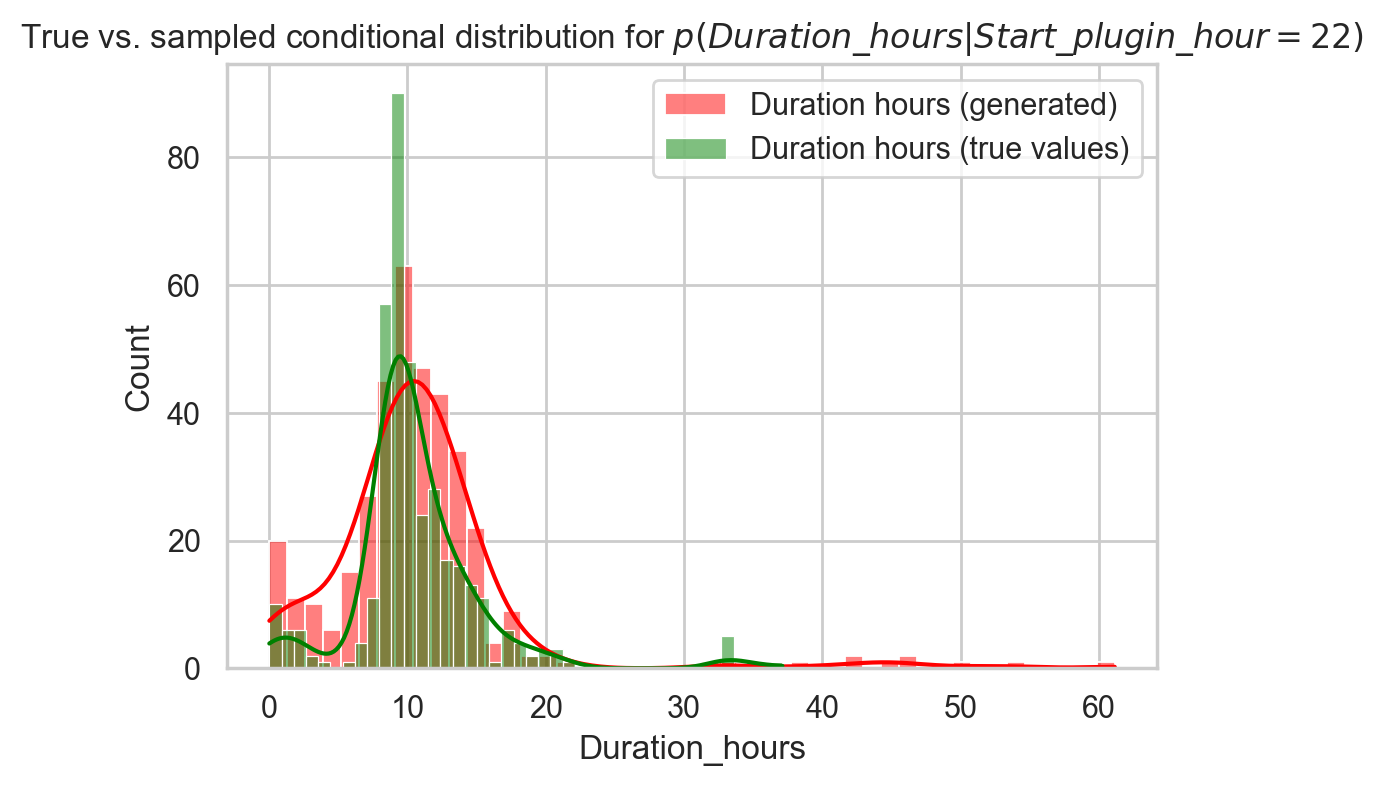

In [36]:
true_data = duration_df[duration_df["Start_plugin_hour"] == conditional]["Duration_hours"]

sample_data = np.empty(0, dtype=float)
for _ in range(len(true_data)):
    mean, cov = get_conditional_for_first_var(
        *select_mixture_component(gm.means_, gm.covariances_, new_weights), conditional
    )
    sample = np.random.multivariate_normal(mean, cov, 1)
    # Sample again if sampled value is smaller or equal to zero
    while sample <= 0:
        sample = np.random.multivariate_normal(mean, cov, 1)
    sample_data = np.append(sample_data, sample)

fig, ax = plt.subplots()
sns.histplot(sample_data, color="red", label="Duration hours (generated)", kde=True, ax=ax)
sns.histplot(true_data, color="green", label="Duration hours (true values)", kde=True, ax=ax)
ax.set_title(
    f"True vs. sampled conditional distribution for $p(Duration\_hours | Start\_plugin\_hour = {conditional})$"
)
ax.legend();